# Working with AWS Trained Models
- less vars
- 2004-2015

## TODO:
- create map of 13 test sites
- schematic of EALSTM
- schematic of calibration/validaation strategy
- table with performance metrics of 13 catchments
- model performance stratified by static variables
- EDIT manuscript

In [8]:
from pathlib import Path
import os
import warnings

%load_ext autoreload
%autoreload 2

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/jovyan/ml_drought


In [9]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 150

In [10]:
data_dir = Path('data/')

assert data_dir.exists()

In [11]:
from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data
from src.analysis.evaluation import join_true_pred_da
from src.models import load_model

# Read in the data

In [12]:
EXPERIMENT =        'one_timestep_forecast' # '2020_04_23:190425_one_timestep_forecast' 
TRUE_EXPERIMENT =   'one_timestep_forecast'
TARGET_VAR =        'discharge_spec'
STATIC_DATA_FILE =  'data.nc' # '2020_04_23:112630_data.nc_'
DYNAMIC_DATA_FILE = 'data.nc'
N_EPOCHS = 100

assert (data_dir / f"models/{EXPERIMENT}").exists()
assert (data_dir / f"features/{TRUE_EXPERIMENT}").exists()

In [13]:
# read in the training data
ds = xr.open_dataset(Path(f'data/features/{TRUE_EXPERIMENT}/{DYNAMIC_DATA_FILE}'))

# static_ds = xr.open_dataset(Path(f'data/features/static/data.nc'))
all_static = xr.open_dataset(Path(f'data/interim/static/data.nc'))
all_static['station_id'] = all_static['station_id'].astype(int)
static = all_static

ds['station_id'] = ds['station_id'].astype(int)

In [14]:
ds

<xarray.Dataset>
Dimensions:              (station_id: 671, time: 16436)
Coordinates:
  * station_id           (station_id) int64 1001 2001 2002 ... 106001 107001
  * time                 (time) datetime64[ns] 1970-10-01 ... 2015-09-30
Data variables:
    precipitation        (time, station_id) float64 ...
    discharge_spec       (time, station_id) float64 ...
    peti                 (time, station_id) float64 ...
    target_var_original  (time, station_id) float64 ...

In [15]:
static

<xarray.Dataset>
Dimensions:                       (station_id: 671)
Coordinates:
  * station_id                    (station_id) int64 1001 2001 ... 106001 107001
Data variables:
    inter_high_perc               (station_id) float64 ...
    inter_mod_perc                (station_id) float64 ...
    inter_low_perc                (station_id) float64 ...
    frac_high_perc                (station_id) float64 ...
    frac_mod_perc                 (station_id) float64 ...
    frac_low_perc                 (station_id) float64 ...
    no_gw_perc                    (station_id) float64 ...
    low_nsig_perc                 (station_id) float64 ...
    nsig_low_perc                 (station_id) float64 ...
    gauge_name                    (station_id) object ...
    gauge_lat                     (station_id) float64 ...
    gauge_lon                     (station_id) float64 ...
    gauge_easting                 (station_id) int64 ...
    gauge_northing                (station_id) int64 ...
    gauge_elev                    (station_id) float64 ...
    area                          (station_id) float64 ...
    dpsbar                        (station_id) float64 ...
    elev_mean                     (station_id) float64 ...
    elev_min                      (station_id) float64 ...
    elev_10                       (station_id) float64 ...
    elev_50                       (station_id) float64 ...
    elev_90                       (station_id) float64 ...
    elev_max                      (station_id) float64 ...
    sand_perc                     (station_id) float64 ...
    sand_perc_missing             (station_id) float64 ...
    silt_perc                     (station_id) float64 ...
    silt_perc_missing             (station_id) float64 ...
    clay_perc                     (station_id) float64 ...
    clay_perc_missing             (station_id) float64 ...
    organic_perc                  (station_id) float64 ...
    organic_perc_missing          (station_id) float64 ...
    bulkdens                      (station_id) float64 ...
    bulkdens_missing              (station_id) float64 ...
    bulkdens_5                    (station_id) float64 ...
    bulkdens_50                   (station_id) float64 ...
    bulkdens_95                   (station_id) float64 ...
    tawc                          (station_id) float64 ...
    tawc_missing                  (station_id) float64 ...
    tawc_5                        (station_id) float64 ...
    tawc_50                       (station_id) float64 ...
    tawc_95                       (station_id) float64 ...
    porosity_cosby                (station_id) float64 ...
    porosity_cosby_missing        (station_id) float64 ...
    porosity_cosby_5              (station_id) float64 ...
    porosity_cosby_50             (station_id) float64 ...
    porosity_cosby_95             (station_id) float64 ...
    porosity_hypres               (station_id) float64 ...
    porosity_hypres_missing       (station_id) float64 ...
    porosity_hypres_5             (station_id) float64 ...
    porosity_hypres_50            (station_id) float64 ...
    porosity_hypres_95            (station_id) float64 ...
    conductivity_cosby            (station_id) float64 ...
    conductivity_cosby_missing    (station_id) float64 ...
    conductivity_cosby_5          (station_id) float64 ...
    conductivity_cosby_50         (station_id) float64 ...
    conductivity_cosby_95         (station_id) float64 ...
    conductivity_hypres           (station_id) float64 ...
    conductivity_hypres_missing   (station_id) float64 ...
    conductivity_hypres_5         (station_id) float64 ...
    conductivity_hypres_50        (station_id) float64 ...
    conductivity_hypres_95        (station_id) float64 ...
    root_depth                    (station_id) float64 ...
    root_depth_missing            (station_id) float64 ...
    root_depth_5                  (station_id) float64 ...
    root_depth_50                 (station_id) flo

# Read Gcloud Model results

In [16]:
d = pd.read_csv(data_dir / 'gcloud/less_vars_2004_2015/results_ealstm_less_vars_2004_1707_1424_E011.csv')
d.station_id.unique().shape

(667,)

In [17]:
print([d.name for d in (data_dir/'gcloud').iterdir()])
print([d.name for d in (data_dir/'gcloud').glob('*_less_vars/*.csv')])

['Counties_and_Unitary_Authorities_April_2019_Boundaries_EW_BFC', 'less_vars_2004_2015', 'results_lstm_less_vars_1307_1717_E015.csv', 'FUSE_bias_table.csv', 'wget-log', 'FUSE_errors.pkl', 'process_models.pkl', 'ealstm_less_vars', 'lstm20', '.ipynb_checkpoints', 'lstm_0807_2105', 'jules_classic.csv', 'plots', 'fuse_ds.nc', 'lstm_less_vars', 'all_lstm_0807_2105_results.csv', 'natural_earth_hires', '3ma509dlakcf720aw8x82aq4tm.zip.1', 'FUSE_nse_all_stations.csv', 'vars', 'FUSE_r2_table.csv', 'lstm_less_vars_2004_2005_final.csv', 'ealstm20', 'FUSE_rmse_table.csv', 'FUSE', 'FUSE_nse_table.csv', 'FUSE_errors.csv']
['results_ealstm_less_vars_1307_2051_E015.csv', 'results_lstm_less_vars_1307_1717_E015.csv']


In [18]:
# lstm_less_vars = pd.read_csv(data_dir / "gcloud/lstm_less_vars/results_lstm_less_vars_1307_1717_E015.csv")
lstm_less_vars = pd.read_csv(data_dir / "gcloud/less_vars_2004_2015/all_lstm_less_vars_2004_1507_1028_results.csv")
lstm_less_vars = lstm_less_vars[["station_id", "time", "obs", "sim_E015"]].rename(columns=dict(sim_E015="sim"))
lstm_less_vars["time"] = pd.to_datetime(lstm_less_vars["time"])

# ealstm_less_vars = pd.read_csv(data_dir / "gcloud/ealstm_less_vars/results_ealstm_less_vars_1307_2051_E015.csv")
# ealstm_less_vars = pd.read_csv(data_dir / "gcloud/less_vars_2004_2015/results_ealstm_less_vars_2004_1507_2033_E007.csv")
ealstm_less_vars = pd.read_csv(data_dir / "gcloud/less_vars_2004_2015/results_ealstm_less_vars_2004_1707_1424_E011.csv")


# ealstm_less_vars = pd.read_csv(data_dir / "gcloud/less_vars_2004_2015/results_ealstm_less_vars_2004_1507_2033_E007.csv")
ealstm_less_vars["time"] = pd.to_datetime(ealstm_less_vars["time"])

In [19]:
lstm_preds = lstm_less_vars.set_index(["station_id", "time"]).to_xarray()
ealstm_preds = ealstm_less_vars.set_index(["station_id", "time"]).to_xarray()

# NOTE: Only show results 2004--2008

In [20]:
lstm_preds = lstm_preds.sel(time=slice('2004-01-01', '2009-01-01'))
ealstm_preds = ealstm_preds.sel(time=slice('2004-01-01', '2009-01-01'))
ealstm_preds

<xarray.Dataset>
Dimensions:     (station_id: 667, time: 1828)
Coordinates:
  * station_id  (station_id) int64 1001 2001 2002 3003 ... 102001 106001 107001
  * time        (time) datetime64[ns] 2004-01-01 2004-01-02 ... 2009-01-01
Data variables:
    obs         (station_id, time) float64 9.16 6.23 5.6 4.45 ... 1.04 0.94 0.95
    sim         (station_id, time) float64 10.6 5.035 4.072 ... 1.324 1.3 1.345

# Hydrographs

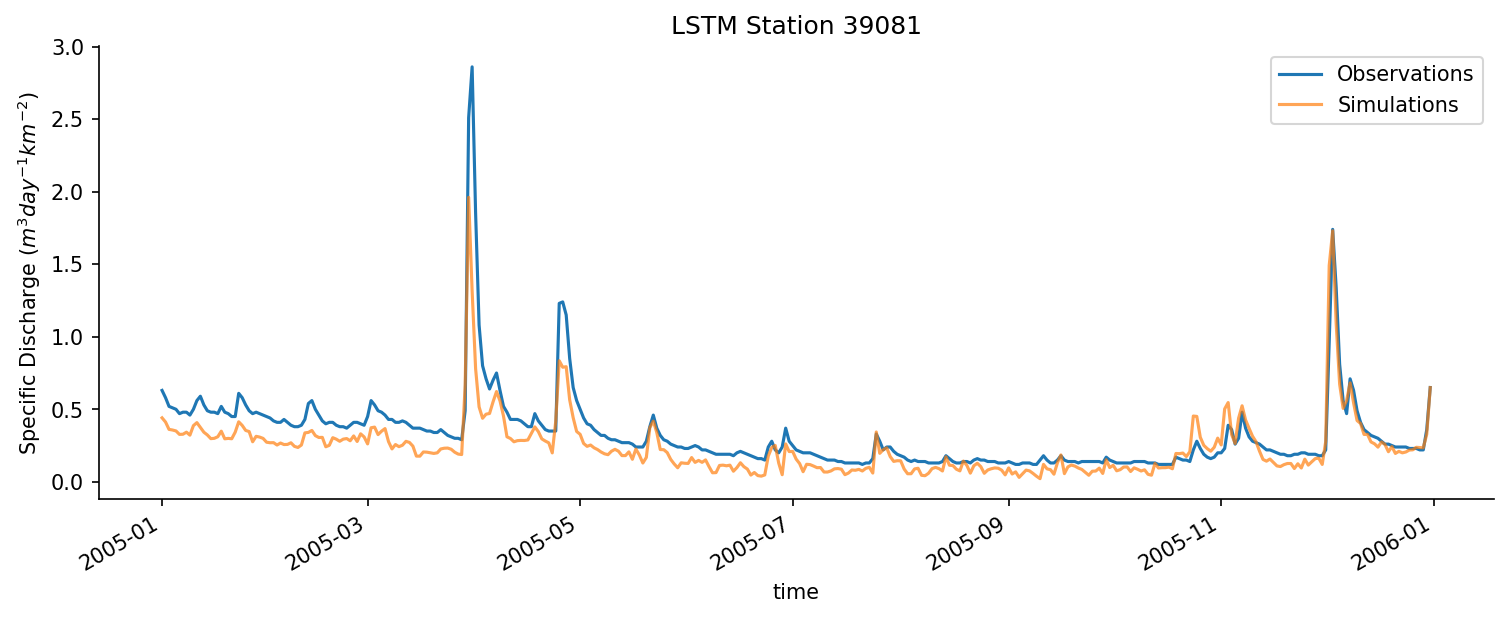

In [21]:
station_id = 39081
fig, ax = plt.subplots(figsize=(12, 4))

lstm_preds.sel(station_id=station_id).sel(time="2005")["obs"].plot(ax=ax, label="Observations")
lstm_preds.sel(station_id=station_id).sel(time="2005")["sim"].plot(ax=ax, label="Simulations", alpha=0.7)
ax.set_ylabel("Specific Discharge ($m^3 day^{-1} km^{-2}$)")
ax.set_title(f"LSTM Station {station_id}")
plt.legend()
sns.despine()

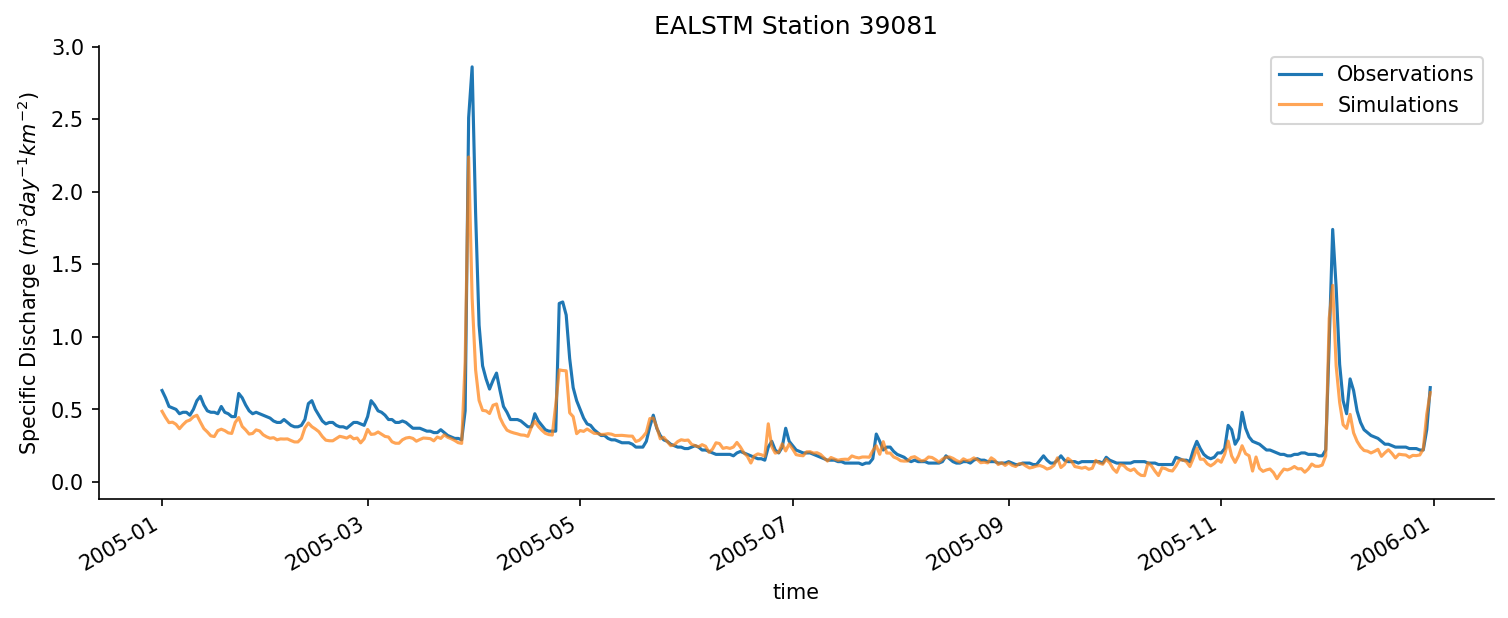

In [22]:
fig, ax = plt.subplots(figsize=(12, 4))
ealstm_preds.sel(station_id=station_id).sel(time="2005")["obs"].plot(ax=ax, label="Observations")
ealstm_preds.sel(station_id=station_id).sel(time="2005")["sim"].plot(ax=ax, label="Simulations", alpha=0.7)
# less_ealstm_preds.isel(station_id=0).sel(time="2010")["sim"].plot(ax=ax, label="Less Vars", alpha=0.7)
ax.set_ylabel("Specific Discharge ($m^3 day^{-1} km^{-2}$)")
ax.set_title(f"EALSTM Station {station_id}")
plt.legend()
sns.despine()

# Error Metrics

In [23]:
from src.analysis.evaluation import spatial_rmse, spatial_r2, spatial_nse, spatial_bias
from src.analysis.evaluation import temporal_rmse, temporal_r2, temporal_nse
from src.analysis.evaluation import _nse_func, _rmse_func, _r2_func, _bias_func

In [24]:
def error_func(preds_xr: xr.Dataset, error_str: str) -> pd.DataFrame:
    lookup = {
        "nse": _nse_func,
        "rmse": _rmse_func,
        "r2": _r2_func,
        "bias": _bias_func,
    }
    error_func = lookup[error_str]
    
    df = preds_xr.to_dataframe()
    df = df.dropna(how='any')
    df = df.reset_index().set_index("time")

    station_ids = df["station_id"].unique()
    errors = []
    for station_id in station_ids:
        d = df.loc[df["station_id"] == station_id]
        if error_str == "rmse":
            _error_calc = error_func(d["obs"].values, d["sim"].values, n_instances=d.size)
        else:
            _error_calc = error_func(d["obs"].values, d["sim"].values)
        errors.append(_error_calc)

    error = pd.DataFrame({"station_id": station_ids, error_str: errors})
    
    return error

In [25]:
errors = [ 
    error_func(ealstm_preds, "nse").set_index('station_id'),
    error_func(ealstm_preds, "r2").set_index('station_id'), 
    error_func(ealstm_preds, "rmse").set_index('station_id'),
    error_func(ealstm_preds, "bias").set_index('station_id'),
]
ealstm_df = errors[0].join(errors[1].join(errors[2]).join(errors[3])).reset_index()

errors = [ 
    error_func(lstm_preds, "nse").set_index('station_id'),
    error_func(lstm_preds, "r2").set_index('station_id'), 
    error_func(lstm_preds, "rmse").set_index('station_id'),
    error_func(lstm_preds, "bias").set_index('station_id'),
]
lstm_df = errors[0].join(errors[1].join(errors[2]).join(errors[3])).reset_index()

In [26]:
lstm_df

station_id       nse        r2      rmse       bias
0          1001  0.805539  0.806728  0.527684   9.650346
1          2001  0.838357  0.839687  0.574231 -10.079839
2          2002  0.855312  0.855384  0.728972  -2.861142
3          3003  0.879971  0.879972  1.256268  -0.342679
4          4001  0.862466  0.862888  0.818045  -3.869403
..          ...       ...       ...       ...        ...
662      101002  0.694080  0.710547  0.211854 -19.911354
663      101005  0.822549  0.823549  0.149159   7.463119
664      102001  0.805450  0.805537  0.808127  -3.544355
665      106001  0.869408  0.869457  0.739264  -1.881066
666      107001  0.771348  0.773461  0.693627  10.590620

[667 rows x 5 columns]

# Plot CDF of NSE

In [27]:
ealstm_nse = (
    error_func(ealstm_preds, "nse")
    .sort_values('nse')
    .reset_index()
    .drop('index', axis=1)
)
lstm_nse = (
    error_func(lstm_preds, "nse")
    .sort_values('nse')
    .reset_index()
    .drop('index', axis=1)
)
ealstm_nse['negative'] = ealstm_nse['nse'] < 0
lstm_nse['negative'] = lstm_nse['nse'] < 0

print(f"LSTM: {lstm_nse['negative'].sum()}")
print(f"EALSTM: {ealstm_nse['negative'].sum()}")

LSTM: 20
EALSTM: 36


In [28]:
def plot_nse_cdf(nse_df, model: str = None):
    median_nse = nse_df.loc[nse_df["nse"] != -np.inf, 'nse'].median()

    scale = 1
    fig, ax = plt.subplots(figsize=(12*scale, 8*scale))

    # plot the points
    ax.scatter(nse_df['nse'], nse_df.index, alpha=0.06)

    ymax = nse_df.index.max()
    ax.axvline(median_nse, ymin=0, ymax=ymax, color='k', ls='--', label='Median NSE', alpha=0.7)

    # beautify the plot
    ax.set_ylim(-5, ymax*1.1)
    ax.set_xlim(-0.1, 1)

    ax.legend()

    ax.set_title(f'{model} Station NSE - Median: {median_nse:.2f}\n{nse_df.negative.sum()} Stations with negative NSE')
    ax.set_xlabel('NSE')
    ax.set_ylabel('Cumulative Number of Stations');

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False);

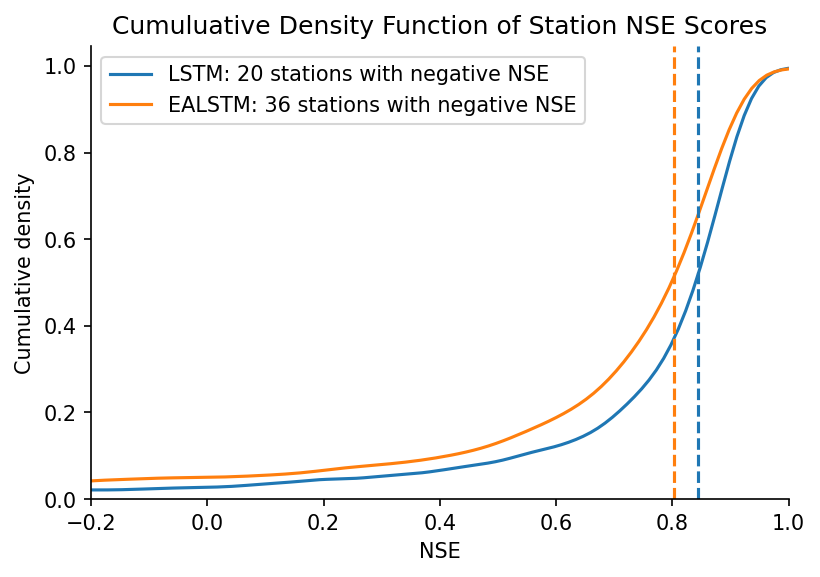

In [29]:
colors = sns.color_palette()

fig, ax = plt.subplots()
sns.kdeplot(
    lstm_nse['nse'], 
    cumulative=True, 
    legend=False, ax=ax, 
    clip=[-0.5,1], 
    label=f"LSTM: {lstm_nse['negative'].sum()} stations with negative NSE"
)
sns.kdeplot(
    ealstm_nse['nse'], 
    cumulative=True, 
    legend=False, ax=ax, 
    clip=[-0.5,1], 
    label=f"EALSTM: {ealstm_nse['negative'].sum()} stations with negative NSE"
)
plt.legend()

ax.axvline(lstm_nse['nse'].median(), ls="--", color=colors[0])
ax.axvline(ealstm_nse['nse'].median(), ls="--", color=colors[1])

ax.set_xlim([-0.2, 1])
ax.set_xlabel("NSE")
ax.set_ylabel("Cumulative density")
title = f"Cumuluative Density Function of Station NSE Scores"
ax.set_title(title)
sns.despine()

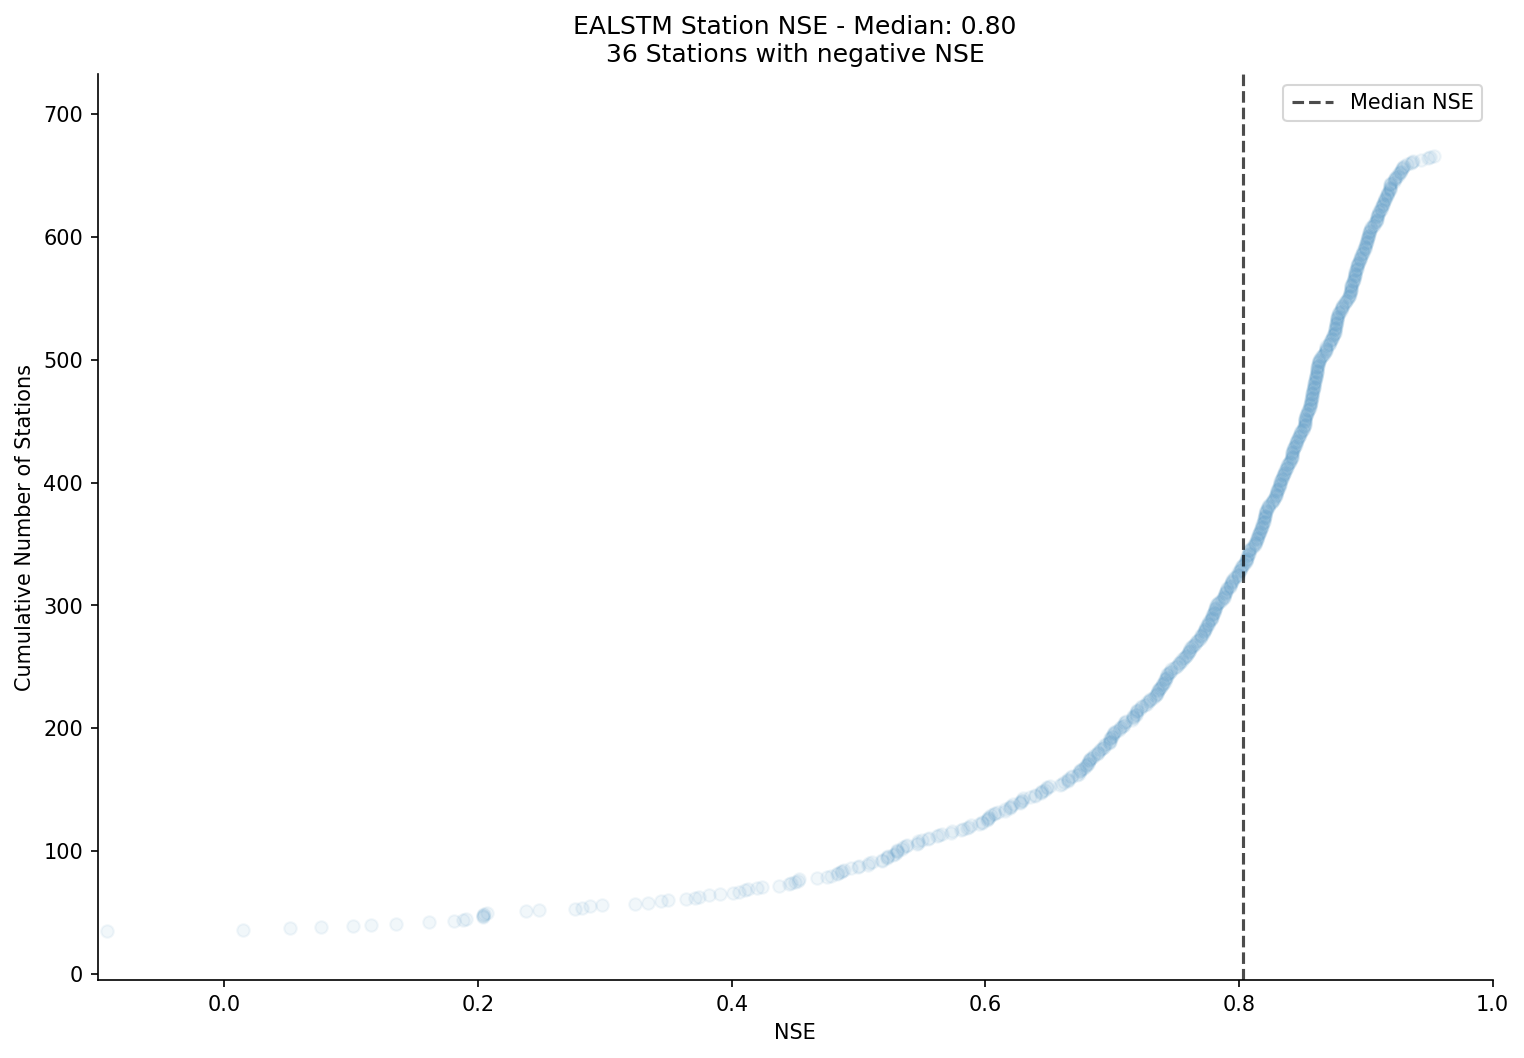

In [30]:
plot_nse_cdf(ealstm_nse, model='EALSTM')

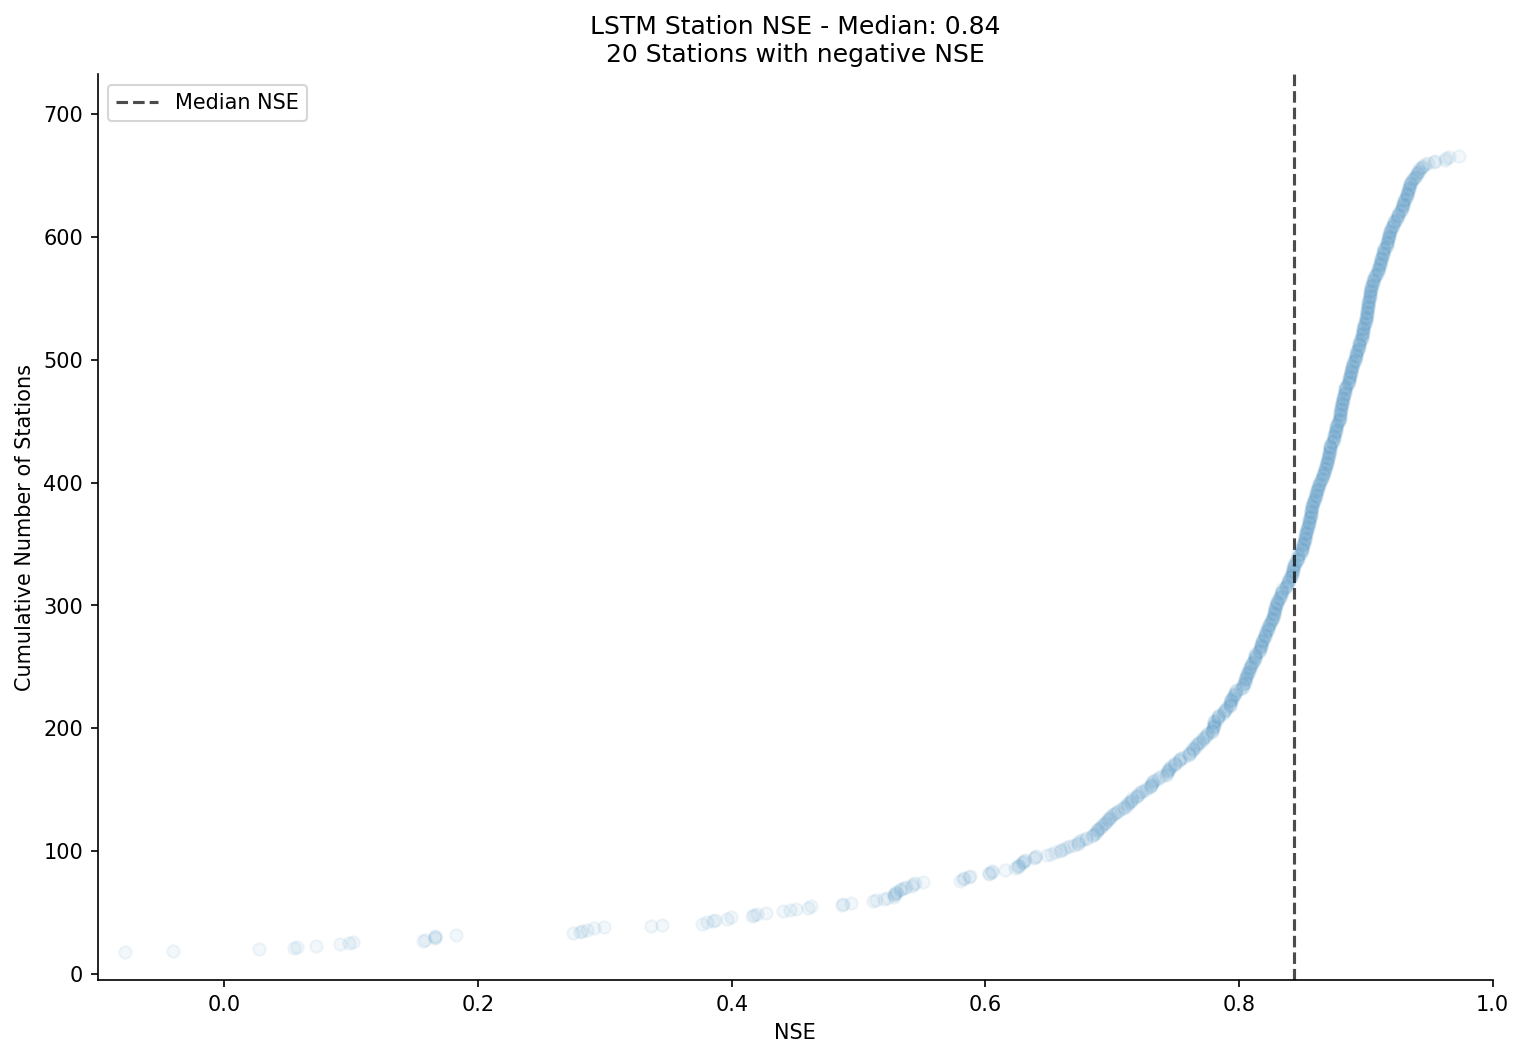

In [31]:
plot_nse_cdf(lstm_nse, model="LSTM")

# 13 catchments

In [32]:
catchment_ids = [int(c) for c in ["12002", "15006", "27009", "27034", "27041", "39001", "39081", "43021", "47001", "54001", "54057", "71001", "84013",]]
catchment_names = ["Dee@Park", "Tay@Ballathie", "Ouse@Skelton", "Ure@Kilgram", "Derwent@Buttercrambe", "Thames@Kingston", "Ock@Abingdon", "Avon@Knapp", "Tamar@Gunnislake", "Severn@Bewdley", "Severn@Haw", "Ribble@Samlesbury", "Clyde@Daldowie"]
station_map = dict(zip(catchment_ids, catchment_names))

In [33]:
names = static['gauge_name'].to_dataframe()

In [34]:
lstm_13 = lstm_df.loc[np.isin(lstm_df["station_id"], catchment_ids)]
lstm_13["catchment_name"] = names.loc[np.isin(names.index, catchment_ids)]
ealstm_13 = ealstm_df.loc[np.isin(ealstm_df["station_id"], catchment_ids)]
ealstm_13["catchment_name"] = names[np.isin(names.index, ealstm_13["station_id"])].values

ealstm_13 = ealstm_13.set_index('station_id')[['catchment_name', 'nse', 'r2', 'rmse', 'bias']]
lstm_13 = lstm_13.set_index('station_id')[['nse', 'r2', 'rmse', 'bias']]

ealstm_13.columns = [["EALSTM" for _ in range(len(ealstm_13.columns))], ealstm_13.columns]
lstm_13.columns = [["LSTM" for _ in range(len(lstm_13.columns))], lstm_13.columns]

models_13 = pd.concat([lstm_13, ealstm_13], axis=1)

In [35]:
latex_df = models_13.rename(columns=dict(nse="NSE", r2="R2", rmse="RMSE", catchment_name="Name"))
latex_df = latex_df.drop(['R2', "RMSE"], axis=1, level=1)
latex_df.index.name = "Station ID"
latex_df

LSTM                              EALSTM                     
                 NSE       bias                     Name       NSE       bias
Station ID                                                                   
12002       0.865097  -0.367802              Dee at Park  0.815284 -14.066988
15006       0.940801  -6.467889         Tay at Ballathie  0.936623  -5.014469
27009       0.905299  -4.555521          Ouse at Skelton  0.857818 -10.808048
27034       0.854989  -2.923608    Ure at Kilgram Bridge  0.860088  -4.393195
27041       0.838245 -11.704940  Derwent at Buttercrambe  0.782031  -7.516467
39001       0.866478   9.245811       Thames at Kingston  0.647355   0.518304
39081       0.672734 -17.426204          Ock at Abingdon  0.508454 -24.505090
43021       0.802895  18.610902       Avon at Knapp Mill  0.629094  -0.763602
47001       0.916621  -3.689431      Tamar at Gunnislake  0.868958  -9.706732
54001       0.917237   1.855498        Severn at Bewdley  0.829054   2.981346
54057       0.866044  -4.153024     Severn at Haw Bridge  0.793239  -9.450364
71001       0.900351  -0.301422     Ribble at Samlesbury  0.865619  -5.433917
84013       0.946685   4.550332        Clyde at Daldowie  0.937095  -5.064306

In [36]:
print(latex_df.to_latex(float_format="%.2f"))

\begin{tabular}{lrrlrr}
\toprule
{} & \multicolumn{2}{l}{LSTM} & \multicolumn{3}{l}{EALSTM} \\
{} &  NSE &   bias &                     Name &  NSE &   bias \\
Station ID &      &        &                          &      &        \\
\midrule
12002      & 0.87 &  -0.37 &              Dee at Park & 0.82 & -14.07 \\
15006      & 0.94 &  -6.47 &         Tay at Ballathie & 0.94 &  -5.01 \\
27009      & 0.91 &  -4.56 &          Ouse at Skelton & 0.86 & -10.81 \\
27034      & 0.85 &  -2.92 &    Ure at Kilgram Bridge & 0.86 &  -4.39 \\
27041      & 0.84 & -11.70 &  Derwent at Buttercrambe & 0.78 &  -7.52 \\
39001      & 0.87 &   9.25 &       Thames at Kingston & 0.65 &   0.52 \\
39081      & 0.67 & -17.43 &          Ock at Abingdon & 0.51 & -24.51 \\
43021      & 0.80 &  18.61 &       Avon at Knapp Mill & 0.63 &  -0.76 \\
47001      & 0.92 &  -3.69 &      Tamar at Gunnislake & 0.87 &  -9.71 \\
54001      & 0.92 &   1.86 &        Severn at Bewdley & 0.83 &   2.98 \\
54057      & 0.87 &  -4.15 &

In [37]:
models_13

LSTM                                                  EALSTM  \
                 nse        r2      rmse       bias           catchment_name   
station_id                                                                     
12002       0.865097  0.865100  0.406098  -0.367802              Dee at Park   
15006       0.940801  0.941155  0.423127  -6.467889         Tay at Ballathie   
27009       0.905299  0.905463  0.285186  -4.555521          Ouse at Skelton   
27034       0.854989  0.855048  0.981468  -2.923608    Ure at Kilgram Bridge   
27041       0.838245  0.843008  0.163408 -11.704940  Derwent at Buttercrambe   
39001       0.866478  0.867500  0.111471   9.245811       Thames at Kingston   
39081       0.672734  0.681497  0.214904 -17.426204          Ock at Abingdon   
43021       0.802895  0.817986  0.145043  18.610902       Avon at Knapp Mill   
47001       0.916621  0.916702  0.413402  -3.689431      Tamar at Gunnislake   
54001       0.917237  0.917265  0.200064   1.855498        Severn at Bewdley   
54057       0.866044  0.866259  0.217528  -4.153024     Severn at Haw Bridge   
71001       0.900351  0.900352  0.669848  -0.301422     Ribble at Samlesbury   
84013       0.946685  0.946773  0.332232   4.550332        Clyde at Daldowie   

                                                     
                 nse        r2      rmse       bias  
station_id                                           
12002       0.815284  0.819718  0.475196 -14.066988  
15006       0.936623  0.936852  0.437802  -5.014469  
27009       0.857818  0.859192  0.349440 -10.808048  
27034       0.860088  0.860216  0.964060  -4.393195  
27041       0.782031  0.784725  0.189688  -7.516467  
39001       0.647355  0.647363  0.181158   0.518304  
39081       0.508454  0.533816  0.263376 -24.505090  
43021       0.629094  0.629145  0.198966  -0.763602  
47001       0.868958  0.869841  0.518261  -9.706732  
54001       0.829054  0.829199  0.287528   2.981346  
54057       0.793239  0.794944  0.270252  -9.450364  
71001       0.865619  0.865843  0.777874  -5.433917  
84013       0.937095  0.937225  0.360876  -5.064306

# Compare to CLASSIC / JULES

In [38]:
process_errors = pd.read_csv(data_dir / "gcloud/jules_classic.csv")

classic = process_errors.loc[process_errors["Model"] == "Classic", :].drop('Model', axis=1)
classic = classic.rename(columns={"ID": "Station ID"}).set_index("Station ID")
classic.columns = [["CLASSIC" for _ in range(len(classic.columns))], classic.columns]

jules = process_errors.loc[process_errors["Model"] == "Jules", :].drop('Model', axis=1)
jules = jules.rename(columns={"ID": "Station ID"}).set_index("Station ID").drop("Name", axis=1)
jules.columns = [["JULES" for _ in range(len(jules.columns))], jules.columns]

process_errors = pd.concat([classic, jules], axis=1)
process_errors.to_pickle(data_dir / "gcloud/process_models.pkl")
process_errors

CLASSIC             JULES      
                                  Name   NSE  Bias   NSE  Bias
Station ID                                                    
12002                     Dee at Park   0.55  -3.4  0.51 -20.0
15006                Tay at Ballathie   0.46  -7.7  0.64 -15.0
27009                 Ouse at Skelton   0.80   3.1  0.69 -18.0
27034           Ure at Kilgram Bridge   0.78   2.8  0.75 -19.0
27041         Derwent at Buttercrambe   0.65  -5.3  0.49 -27.0
39001              Thames at Kingston   0.81  -5.9  0.82 -11.0
39081                 Ock at Abingdon   0.80 -13.6 -0.21 -63.0
43021              Avon at Knapp Mill   0.60 -17.6 -0.07 -20.0
47001             Tamar at Gunnislake   0.82   0.6  0.63 -18.0
54001               Severn at Bewdley   0.66   4.6  0.61  -7.0
54057            Severn at Haw Bridge   0.78   2.1  0.72 -14.0
71001            Ribble at Samlesbury   0.73   0.4  0.74 -18.0
84013               Clyde at Daldowie   0.80  -2.5  0.82 -24.0

### compare to FUSE

In [40]:
fuse_errors = pd.read_pickle(data_dir / 'gcloud/FUSE_errors.pkl')
fuse_errors = fuse_errors.drop('time', axis=1, level=1).swaplevel(axis=1).sort_index(axis=1)
fuse13 = fuse_errors.loc[np.isin(fuse_errors.index, catchment_ids)]
fuse_errors.head()

bias                                   \
                 PRMS Sacramento   TOPMODEL        VIC   
station_id                                               
1001        12.959633   9.154312   5.374468  16.555672   
2001        -1.387481 -10.049628  -9.247812  -4.731616   
2002        -3.620416  -5.275559  -7.768279  -2.018369   
3003         0.064970  -0.250514  -1.354333  -0.665297   
4001       -10.896440 -15.224478 -13.168926  -3.269556   

                                nse                                           \
                               Name      PRMS Sacramento  TOPMODEL       VIC   
station_id                                                                     
1001                Wick at Tarroul  0.810740   0.833511  0.806001  0.782846   
2001         Helmsdale at Kilphedir  0.733039   0.745913  0.702887  0.724460   
2002           Brora at Bruachrobie  0.754227   0.753752  0.759962  0.731940   
3003        Oykel at Easter Turnaig  0.820548   0.830304  0.826229  0.818363   
4001            Conon at Moy Bridge  0.761567   0.794666  0.730351  0.814088   

                  r2                                     rmse             \
                PRMS Sacramento  TOPMODEL       VIC      PRMS Sacramento   
station_id                                                                 
1001        0.817285   0.837479  0.809666  0.793040  0.901831   0.845843   
2001        0.734121   0.748019  0.706194  0.724825  1.278431   1.247226   
2002        0.760109   0.761248  0.768166  0.736821  1.645850   1.647439   
3003        0.847381   0.856804  0.853982  0.844341  2.661060   2.587714   
4001        0.867002   0.887485  0.853633  0.894459  1.865888   1.731542   

                                
            TOPMODEL       VIC  
station_id                      
1001        0.913054  0.966006  
2001        1.348697  1.298811  
2002        1.626535  1.718855  
3003        2.618600  2.677211  
4001        1.984275  1.647614

In [41]:
# print(fuse13.to_latex(float_format="%.2f"))

In [42]:
fuse_nse = pd.read_csv(data_dir / 'gcloud/FUSE_nse_table.csv')
fuse_rmse = pd.read_csv(data_dir / 'gcloud/FUSE_rmse_table.csv')
fuse_r2 = pd.read_csv(data_dir / 'gcloud/FUSE_r2_table.csv')
fuse_bias = pd.read_csv(data_dir / 'gcloud/FUSE_bias_table.csv')

In [53]:
fuse_nse_df = nse = fuse_nse.set_index("station_id").join(
    ealstm_df.set_index("station_id")["nse"].rename("EALSTM")
)
nse = nse.join(
    lstm_df.set_index("station_id")["nse"].rename("LSTM")
)

In [54]:
nse = fuse_nse.set_index("station_id").join(
    ealstm_df.set_index("station_id")["nse"].rename("EALSTM")
)
nse = nse.join(
    lstm_df.set_index("station_id")["nse"].rename("LSTM")
)

rmse = fuse_rmse.set_index("station_id").join(
    ealstm_df.set_index("station_id")["rmse"].rename("EALSTM")
)
rmse = rmse.join(
    lstm_df.set_index("station_id")["rmse"].rename("LSTM")
)
rmse['Name'] = nse["Name"]
rmse = rmse[["Name"] + [c for c in rmse.columns if c != "Name"]]

# 
r2 = fuse_r2.set_index("station_id").join(
    ealstm_df.set_index("station_id")["r2"].rename("EALSTM")
)
r2 = r2.join(
    lstm_df.set_index("station_id")["r2"].rename("LSTM")
)
r2['Name'] = nse["Name"]
r2 = r2[["Name"] + [c for c in r2.columns if c != "Name"]]


## BIAS
bias = fuse_bias.set_index("station_id").join(
    ealstm_df.set_index("station_id")["bias"].rename("EALSTM")
)
bias = bias.join(
    lstm_df.set_index("station_id")["bias"].rename("LSTM")
)
bias['Name'] = nse["Name"]
bias = bias[["Name"] + [c for c in bias.columns if c != "Name"]]

In [55]:
nse_13 = nse.loc[catchment_ids]
nse_13.index.name = "Station ID"
rmse_13 = rmse.loc[catchment_ids]
rmse_13.index.name = "Station ID"
r2_13 = r2.loc[catchment_ids]
r2_13.index.name = "Station ID"
bias_13 = bias.loc[catchment_ids]
bias_13.index.name = "Station ID"

In [56]:
all_bias = bias_13.join(process_errors.drop(["NSE", "Name"], axis=1, level=1).droplevel(axis=1, level=1))

# 

In [58]:
all_nse = nse_13.join(process_errors.drop(["Bias", "Name"], axis=1, level=1).droplevel(axis=1, level=1))

In [193]:
# print(all_nse.to_latex(float_format="%.2f"))

\begin{tabular}{llrrrrrrrr}
\toprule
{} &                     Name &  TOPMODEL &  VIC &  PRMS &  Sacramento &  EALSTM &  LSTM &  CLASSIC &  JULES \\
Station ID &                          &           &      &       &             &         &       &          &        \\
\midrule
12002      &              Dee at Park &      0.56 & 0.63 &  0.65 &        0.65 &    0.82 &  0.87 &     0.55 &   0.51 \\
15006      &         Tay at Ballathie &      0.80 & 0.89 &  0.86 &        0.88 &    0.94 &  0.94 &     0.46 &   0.64 \\
27009      &          Ouse at Skelton &      0.86 & 0.89 &  0.88 &        0.90 &    0.86 &  0.91 &     0.80 &   0.69 \\
27034      &    Ure at Kilgram Bridge &      0.84 & 0.85 &  0.85 &        0.85 &    0.86 &  0.85 &     0.78 &   0.75 \\
27041      &  Derwent at Buttercrambe &      0.75 & 0.71 &  0.78 &        0.81 &    0.78 &  0.84 &     0.65 &   0.49 \\
39001      &       Thames at Kingston &      0.73 & 0.73 &  0.63 &        0.82 &    0.65 &  0.87 &     0.81 &   0.82 \\
39

Name   TOPMODEL        VIC       PRMS  \
Station ID                                                             
12002                   Dee at Park  -5.942977   7.123732  -3.035800   
15006              Tay at Ballathie  -8.805878   7.224393  -7.013328   
27009               Ouse at Skelton   3.980303   8.811956   3.035358   
27034         Ure at Kilgram Bridge  -6.602561  -3.456757  -0.921798   
27041       Derwent at Buttercrambe   1.412459  20.457355  10.312414   
39001            Thames at Kingston  16.526875  17.653984  46.282385   
39081               Ock at Abingdon -11.849456 -10.369773  -5.997321   
43021            Avon at Knapp Mill  33.324338  13.060202  15.555114   
47001           Tamar at Gunnislake  -5.974199  14.790210  -2.664355   
54001             Severn at Bewdley  18.927446   7.134334  13.466011   
54057          Severn at Haw Bridge   7.810071   8.877016   3.802692   
71001          Ribble at Samlesbury   0.833191   4.358927   0.327128   
84013             Clyde at Daldowie   1.668957  15.913328   7.981717   

            Sacramento     EALSTM       LSTM  CLASSIC  JULES  
Station ID                                                    
12002        -7.205577 -14.066988  -0.367802     -3.4  -20.0  
15006        -8.619510  -5.014469  -6.467889     -7.7  -15.0  
27009         3.375319 -10.808048  -4.555521      3.1  -18.0  
27034        -9.449231  -4.393195  -2.923608      2.8  -19.0  
27041        10.898775  -7.516467 -11.704940     -5.3  -27.0  
39001        21.184702   0.518304   9.245811     -5.9  -11.0  
39081       -16.376295 -24.505090 -17.426204    -13.6  -63.0  
43021         6.302035  -0.763602  18.610902    -17.6  -20.0  
47001        -4.217859  -9.706732  -3.689431      0.6  -18.0  
54001        11.820826   2.981346   1.855498      4.6   -7.0  
54057         2.524775  -9.450364  -4.153024      2.1  -14.0  
71001        -1.967546  -5.433917  -0.301422      0.4  -18.0  
84013         2.600944  -5.064306   4.550332     -2.5  -24.0

# Diagram with FUSE

In [68]:
fuse_nse_df = fuse_nse_df.drop("EALSTM", axis=1)

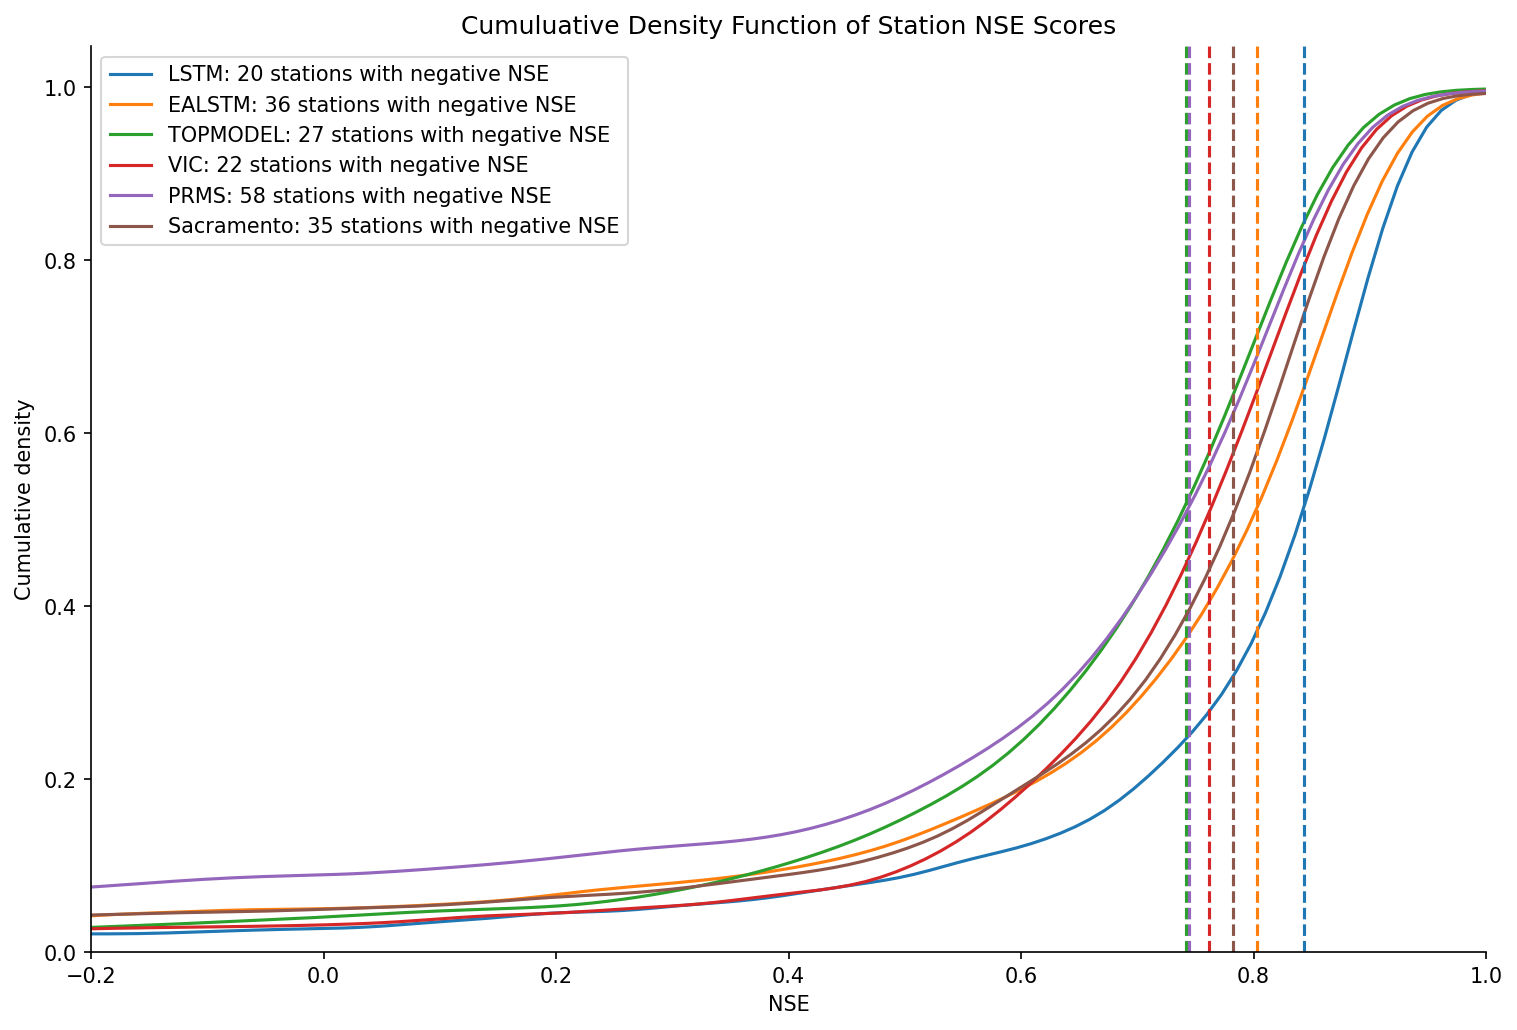

In [69]:
colors = sns.color_palette()

fig, ax = plt.subplots(figsize=(12, 8))
sns.kdeplot(
    lstm_nse['nse'], 
    cumulative=True, 
    legend=False, ax=ax, 
    clip=[-0.5,1], 
    label=f"LSTM: {lstm_nse['negative'].sum()} stations with negative NSE"
)
sns.kdeplot(
    ealstm_nse['nse'], 
    cumulative=True, 
    legend=False, ax=ax, 
    clip=[-0.5,1], 
    label=f"EALSTM: {ealstm_nse['negative'].sum()} stations with negative NSE"
)

for conceptual_ix, model in enumerate([c for c in fuse_nse_df.columns if (not "Name" in c) and (not "station" in c)]):
    sns.kdeplot(
        fuse_nse_df[model].dropna(), 
        cumulative=True, 
        legend=False, ax=ax, 
        clip=[-0.5,1], 
        label=f"{model}: {(fuse_nse_df[model] < 0).sum()} stations with negative NSE"
    )
    plt.legend()
    ax.axvline(fuse_nse_df[model].dropna().median(), ls="--", color=colors[conceptual_ix+2])


ax.axvline(lstm_nse['nse'].median(), ls="--", color=colors[0])
ax.axvline(ealstm_nse['nse'].median(), ls="--", color=colors[1])

ax.set_xlim([-0.2, 1])
ax.set_xlabel("NSE")
ax.set_ylabel("Cumulative density")
title = f"Cumuluative Density Function of Station NSE Scores"
ax.set_title(title)
sns.despine()

In [108]:
fuse_bias = fuse_errors.loc[:, np.array([np.array(c) for c in fuse_errors.columns])[:, 0] == 'bias'].droplevel(axis=1, level=0)
fuse_bias

PRMS  Sacramento   TOPMODEL        VIC
station_id                                             
1001        12.959633    9.154312   5.374468  16.555672
2001        -1.387481  -10.049628  -9.247812  -4.731616
2002        -3.620416   -5.275559  -7.768279  -2.018369
3003         0.064970   -0.250514  -1.354333  -0.665297
4001       -10.896440  -15.224478 -13.168926  -3.269556
...               ...         ...        ...        ...
101002       9.113285  -14.195736  10.710749  -6.368953
101005      45.755884    2.344623 -21.583407  26.253056
102001       0.302688    2.641035  -4.830856  17.373095
106001      -9.491457  -11.259070 -12.823300  -4.030308
107001            NaN         NaN        NaN        NaN

[671 rows x 4 columns]

LSTM
------


station_id    39120.000000
nse              -9.217719
r2               -0.081628
rmse              0.249028
bias            636.551308
Name: 329, dtype: float64


EALSTM
------


station_id    39120.000000
nse             -18.670348
r2               -0.205649
rmse              0.345523
bias            857.141882
Name: 329, dtype: float64

In [ ]:
def bias(observed: np.ndarray, predicted: np.ndarray):
    return 100 * (
        (predicted.mean() / observed.mean()
        ) - 1)

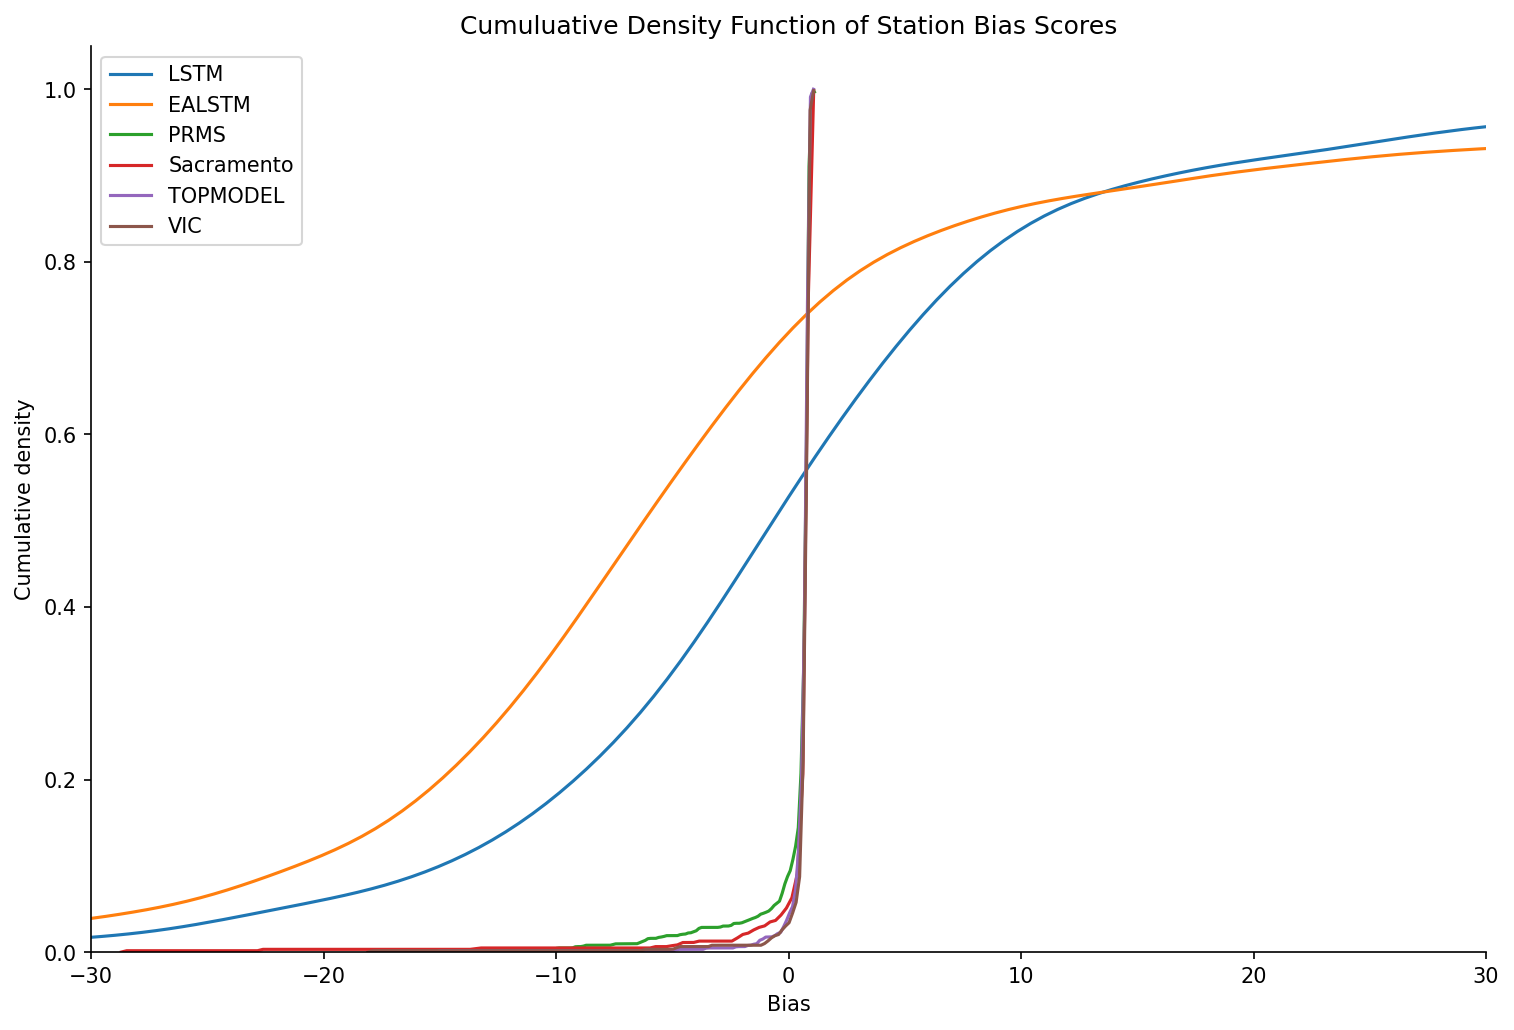

In [141]:
colors = sns.color_palette()

fig, ax = plt.subplots(figsize=(12, 8))
sns.kdeplot(
    lstm_df['bias'], 
    cumulative=True, 
    legend=False, ax=ax, 
    clip=[-30, 30], 
    label=f"LSTM"
)
sns.kdeplot(
    ealstm_df['bias'],
    cumulative=True, 
    legend=False, ax=ax, 
    clip=[-30, 30], 
    label=f"EALSTM"
)

for conceptual_ix, model in enumerate([model for model in fuse_bias]):
    sns.kdeplot(
        fuse_nse_df[model].dropna(), 
        cumulative=True, 
        legend=False, ax=ax, 
        label=f"{model}",
        clip=[-30, 30],
    )
    plt.legend()
#     ax.axvline(fuse_nse_df[model].dropna().median(), ls="--", color=colors[conceptual_ix+2])


# ax.axvline(lstm_nse['nse'].median(), ls="--", color=colors[0])
# ax.axvline(ealstm_nse['nse'].median(), ls="--", color=colors[1])

ax.set_xlim([-30, 30])
ax.set_xlabel("Bias")
ax.set_ylabel("Cumulative density")
title = f"Cumuluative Density Function of Station Bias Scores"
ax.set_title(title)
plt.legend()
sns.despine()

In [137]:
[fuse_bias[m].max() for m in fuse_bias.columns]

[670.2672419624132, 355.65216233830216, 125.72563080146679, 399.93664447721767]

In [131]:
print("LSTM\n------")
display(lstm_df.iloc[np.abs(lstm_df['bias']).argmax()])
print()
print("EALSTM\n------")
display(ealstm_df.iloc[np.abs(ealstm_df['bias']).argmax()])

for model in [c for c in fuse_bias.columns]:
    print()
    print(f"{model}\n------")
    display(fuse_bias.loc[np.abs(fuse_bias[model]).dropna().argmax(), model])

LSTM
------


station_id    39120.000000
nse              -9.217719
r2               -0.081628
rmse              0.249028
bias            636.551308
Name: 329, dtype: float64


EALSTM
------


station_id    39120.000000
nse             -18.670348
r2               -0.205649
rmse              0.345523
bias            857.141882
Name: 329, dtype: float64


PRMS
------


670.2672419624132


Sacramento
------


355.65216233830216


TOPMODEL
------


125.72563080146679


VIC
------


399.93664447721767

## plot function

In [259]:
from typing import (Tuple, Dict, Optional, List, Union, Any)

def remove_invalid_vals(x, y) -> Tuple[np.ndarray, np.ndarray]:
    """check for infinite or nan values
    
    Required for np.polyfit:
    https://stackoverflow.com/a/13693657/9940782
    """
    isfinite = np.isfinite(y) & np.isfinite(x)
    notnull = pd.notnull(y) & pd.notnull(x)
    
    x = x[isfinite & notnull]
    y = y[isfinite & notnull]
    
    return x, y
    

def plot_1_1_line(x: np.ndarray, ax) -> plt.Axes:
    # plot 1:1 line
    line_1_1_x = np.linspace(x.min(), x.max(), 10)
    ax.plot(line_1_1_x, line_1_1_x, 'k--', label='1:1 Line', alpha=0.5)
    return ax


def plot_scatter(x: np.ndarray, y: np.ndarray, ax, one_to_one: bool = True, **kwargs) -> plt.Axes:
    """Scatter plot of x vs. y"""
    # plot scatter
    ax.plot(x, y, 'kx', **kwargs)
    
    if one_to_one:
        # plot 1:1 line
        ax = plot_1_1_line(x, ax)

    return ax


def plot_reg_line(x: np.ndarray, y: np.ndarray, ax, auto_label: bool = False, **kwargs):
    """plot linear regression line of x vs. y"""
    # plot regression line
    x, y = remove_invalid_vals(x, y)
    m, b = np.polyfit(x, y, 1)
    reg = (m * x + b)
    if auto_label:
        label = f'Regression Line: {m:.2f}X + {b:.2f}'
        ax.plot(x, reg, label=label, **kwargs)
    else:
        ax.plot(x, reg, **kwargs)

    return ax


def plot_station_scatter(
    df: pd.DataFrame, station_id: str, metrics_df: Optional[pd.DataFrame] = None, ax=None,
    target_var: str = 'discharge_spec',
    station_name: Optional[str] = None
):
    # select station & data
    d = df.query(f"station_id == '{station_id}'").drop(columns='station_id')
    x = d[target_var]
    y = d.preds
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    else:
        fig = plt.gcf()
    
    # plot scatter
    kwargs = dict(alpha=0.6, label='Data Point')
    ax = plot_scatter(x, y, ax, **kwargs)

    # plot regression line
    kwargs = dict(color = '#7bd250', ls='--')
    ax = plot_reg_line(x, y, ax=ax, **kwargs)

    # make the plot pretty
    ax.set_xlabel('Observed')
    ax.set_ylabel('Predicted')
    title = f'Station {station_id}' + f" {station_name}" if station_name is not None else f'Station {station_id}'
    ax.set_title(title)

    ax.legend();
    
    if False:
        # making the plot pretty
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]
                          + ax.get_xticklabels() + ax.get_yticklabels()):
                item.set_fontsize(12)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    return fig, ax


def plot_station(
    df: pd.DataFrame, 
    station_id: str, 
    metrics_df: Optional[pd.DataFrame] = None, 
    ax=None,
    station_name: Optional[str] = None,
    plot_years: Optional[List[int]] = None,
):
    """Plot the Observed vs. Preds for the station_id"""
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = plt.gcf()
    
    if 'month' in df.columns:
        df = df.drop(columns='month')
    
    # plot the station
    if plot_years is None:
        df.query(f"station_id == '{station_id}'").drop(columns='station_id').plot(ax=ax)
    else:
        (
            df.loc[np.isin(df.index.year, plot_years)]
            .query(f"station_id == '{station_id}'")
            .drop(columns='station_id').plot(ax=ax)
        )
    
    # get the error metrics
    rmse_val = metrics_df.query(f"station_id == '{station_id}'").rmse.values[0]
    r2_val = metrics_df.query(f"station_id == '{station_id}'").r2.values[0]
    nse_val = metrics_df.query(f"station_id == '{station_id}'").nse.values[0]
    # set the title
    station_title = f"{station_id} {station_name}" if station_name is not None else station_id
    ax.set_title(f"{station_title}\nRMSE: {rmse_val:.2f} R2: {r2_val:.2f} NSE: {nse_val:.2f}")
    
    return fig, ax

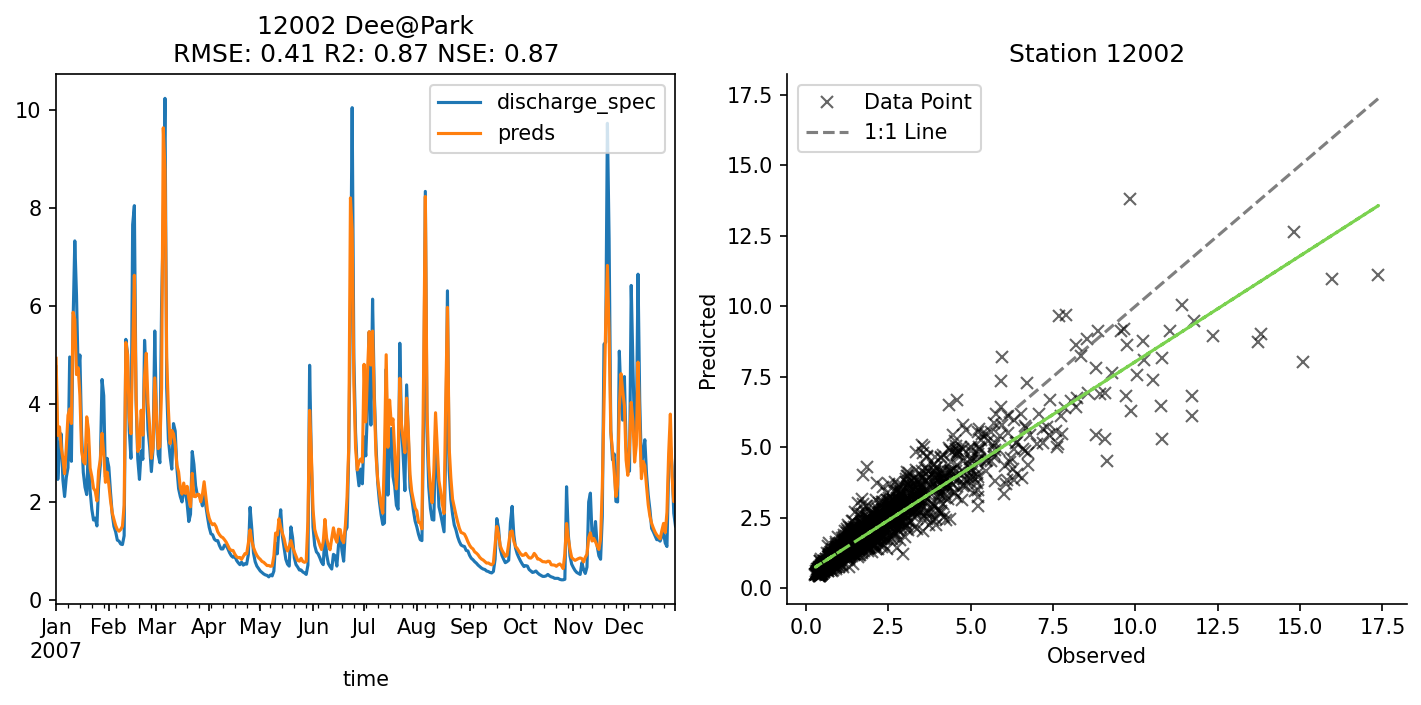

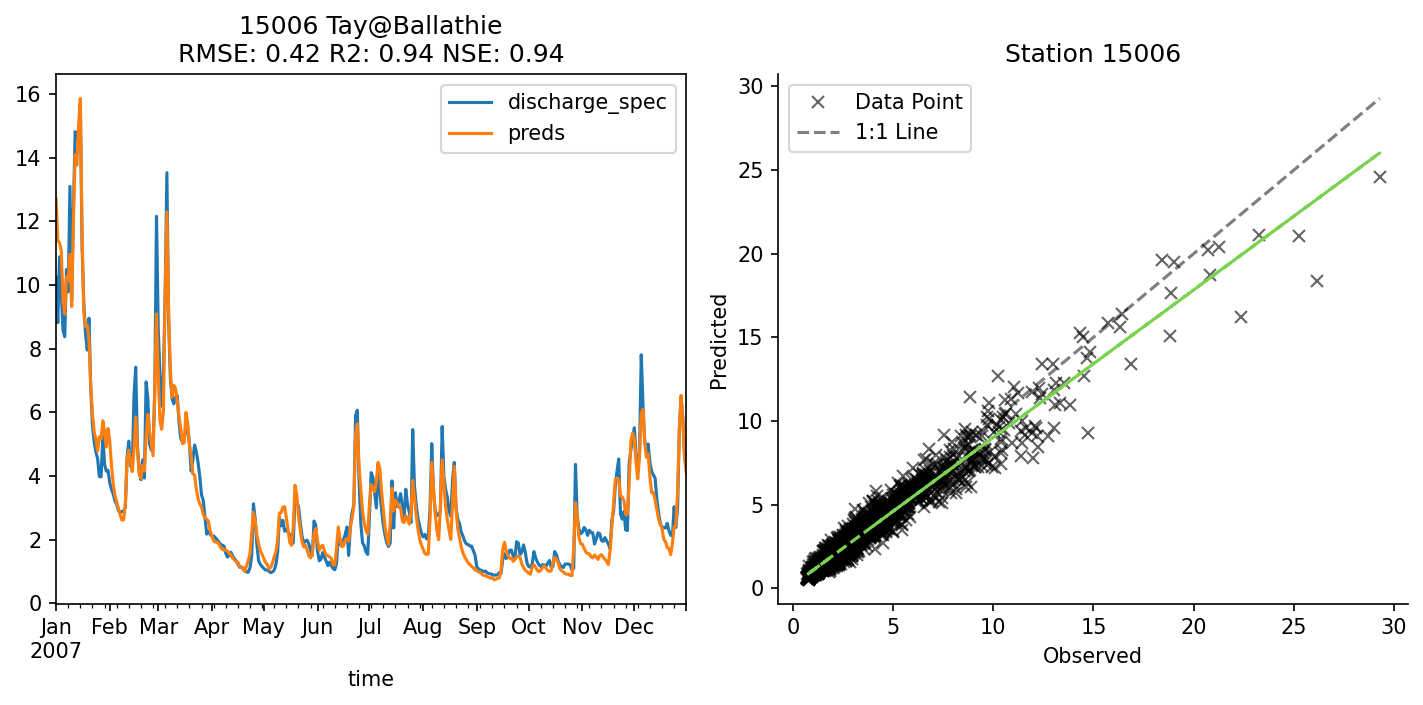

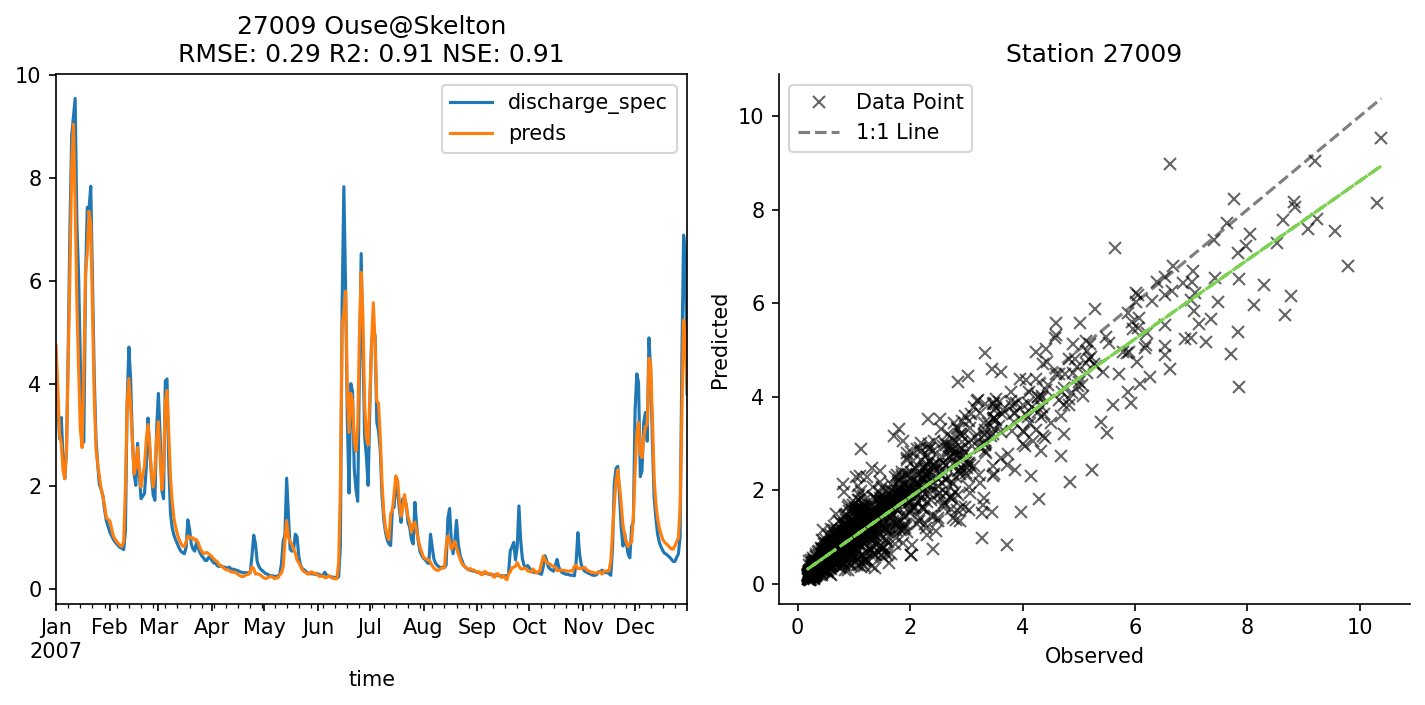

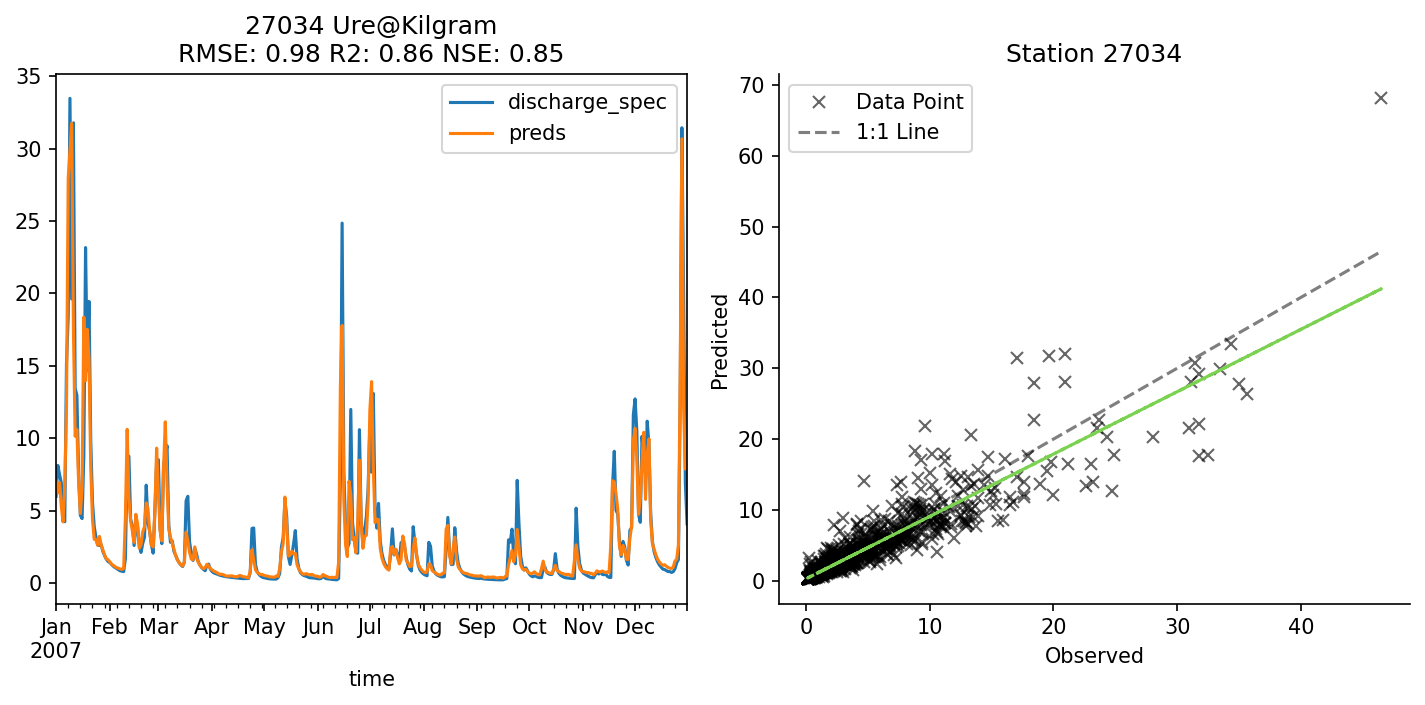

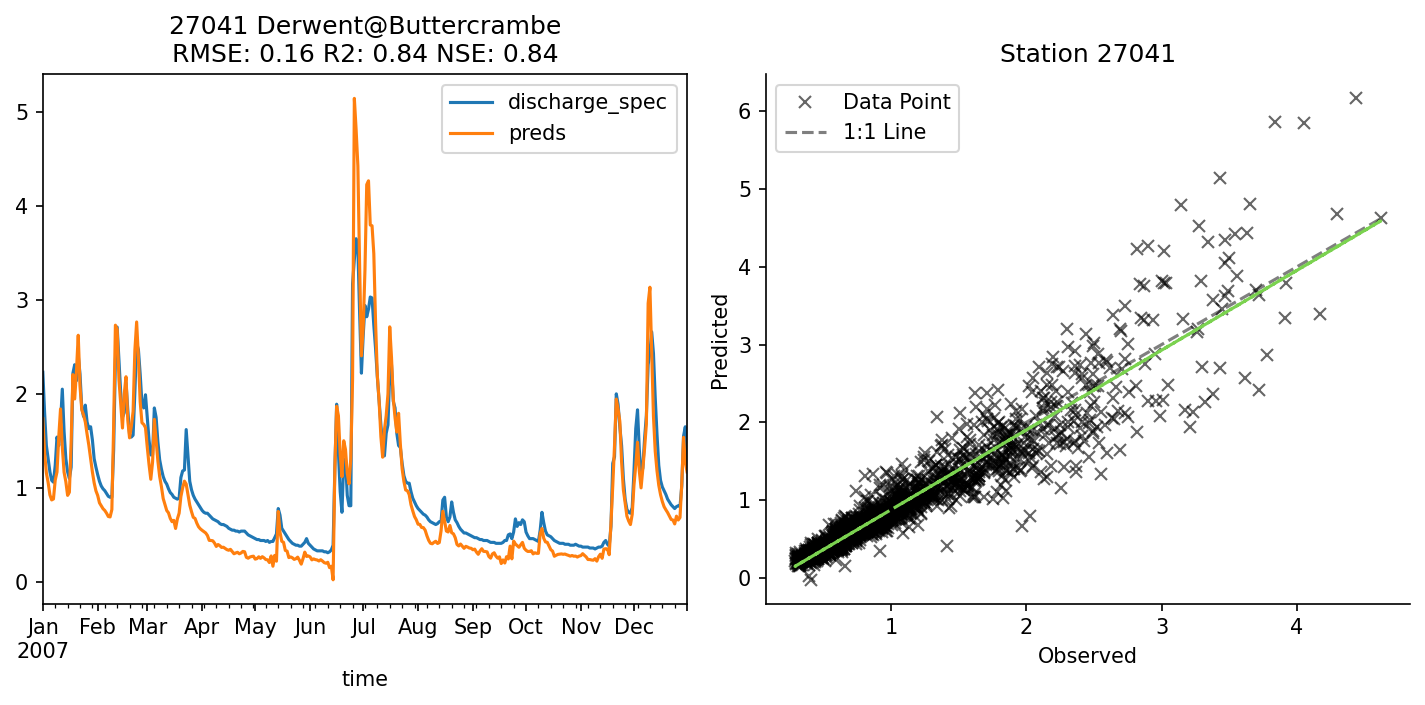

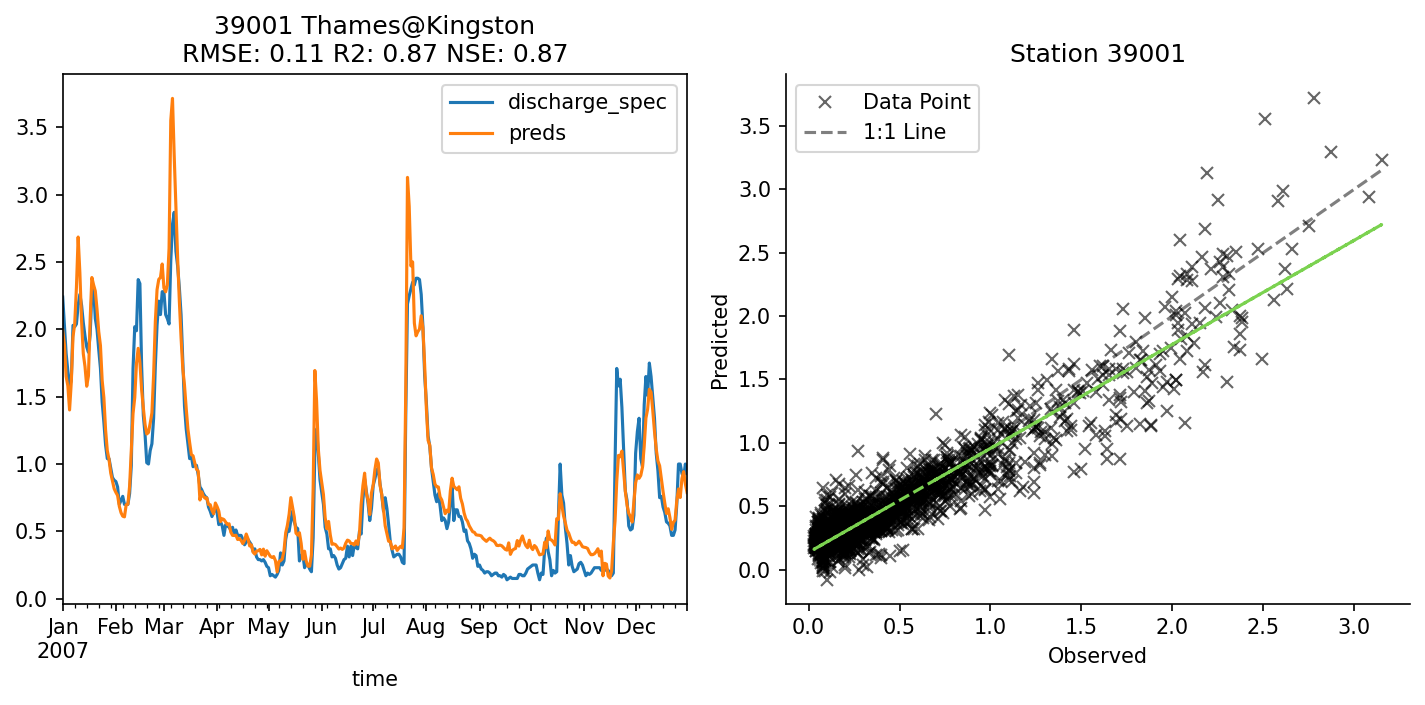

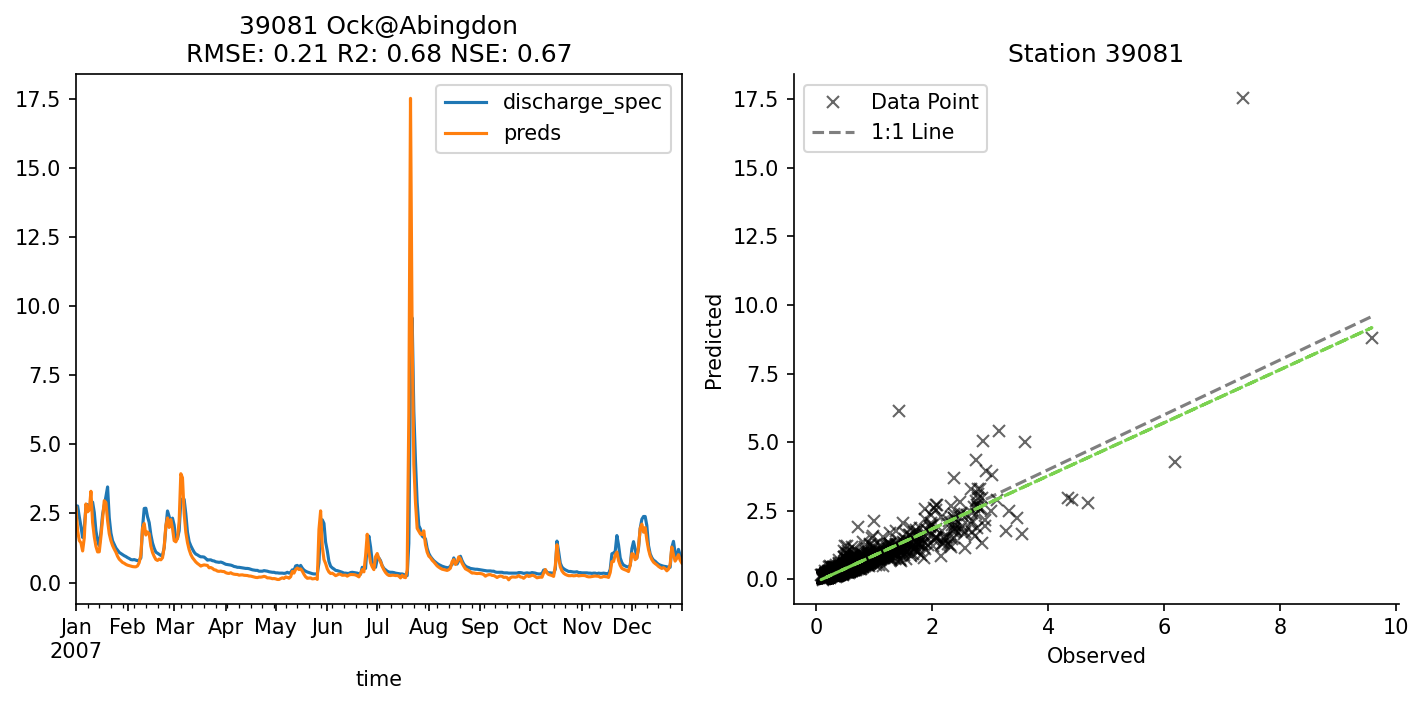

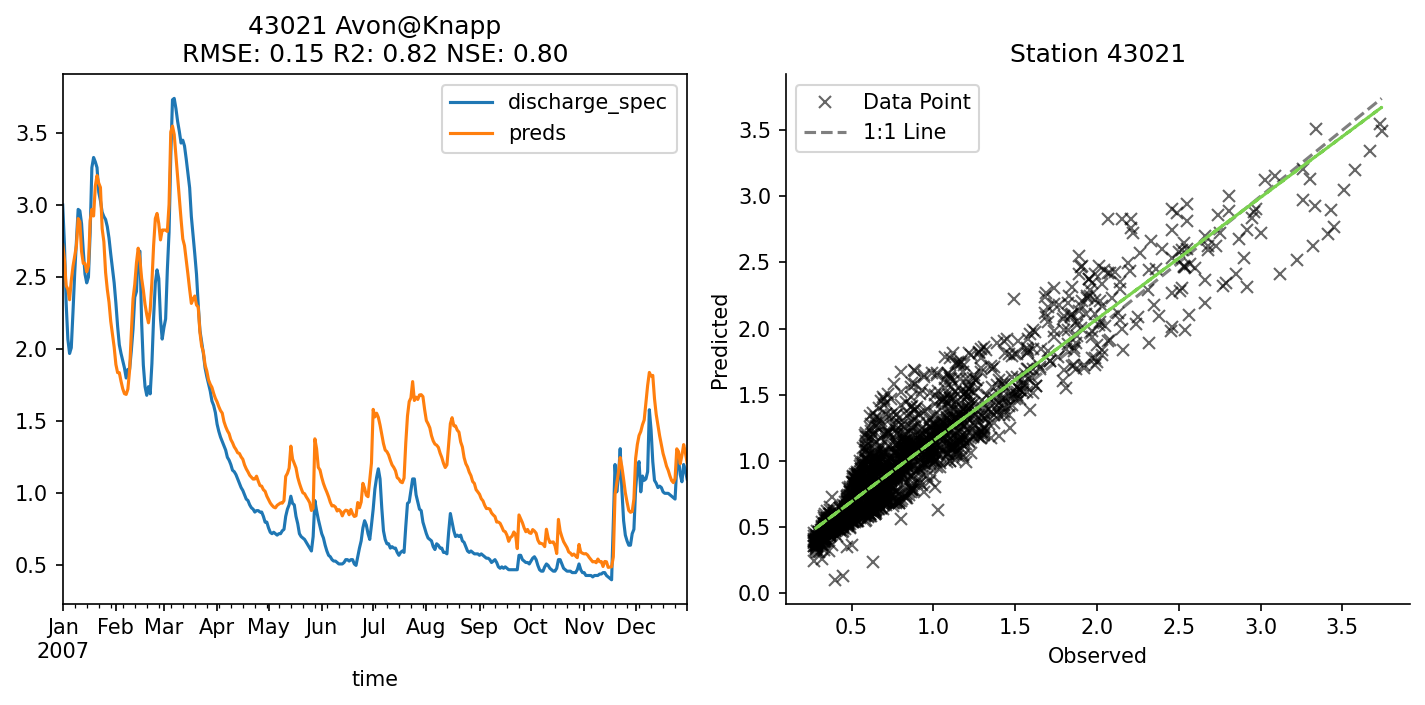

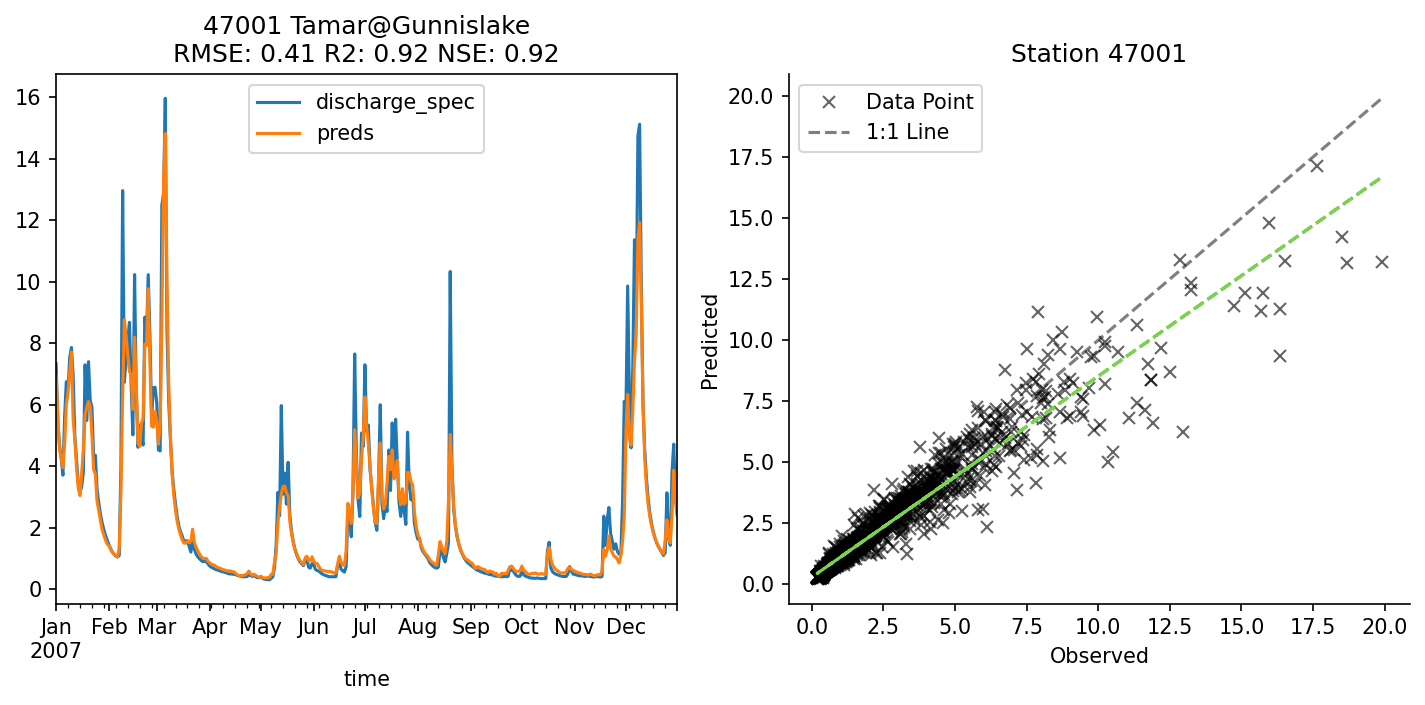

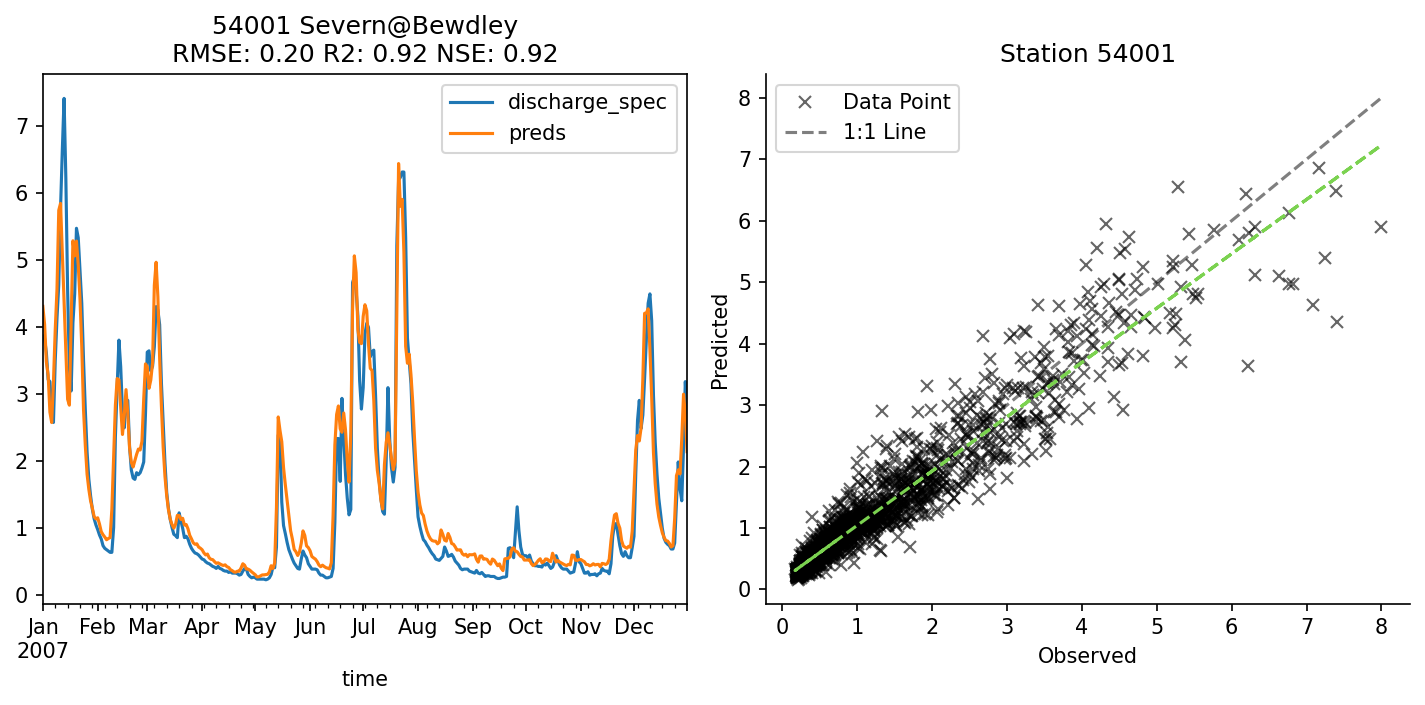

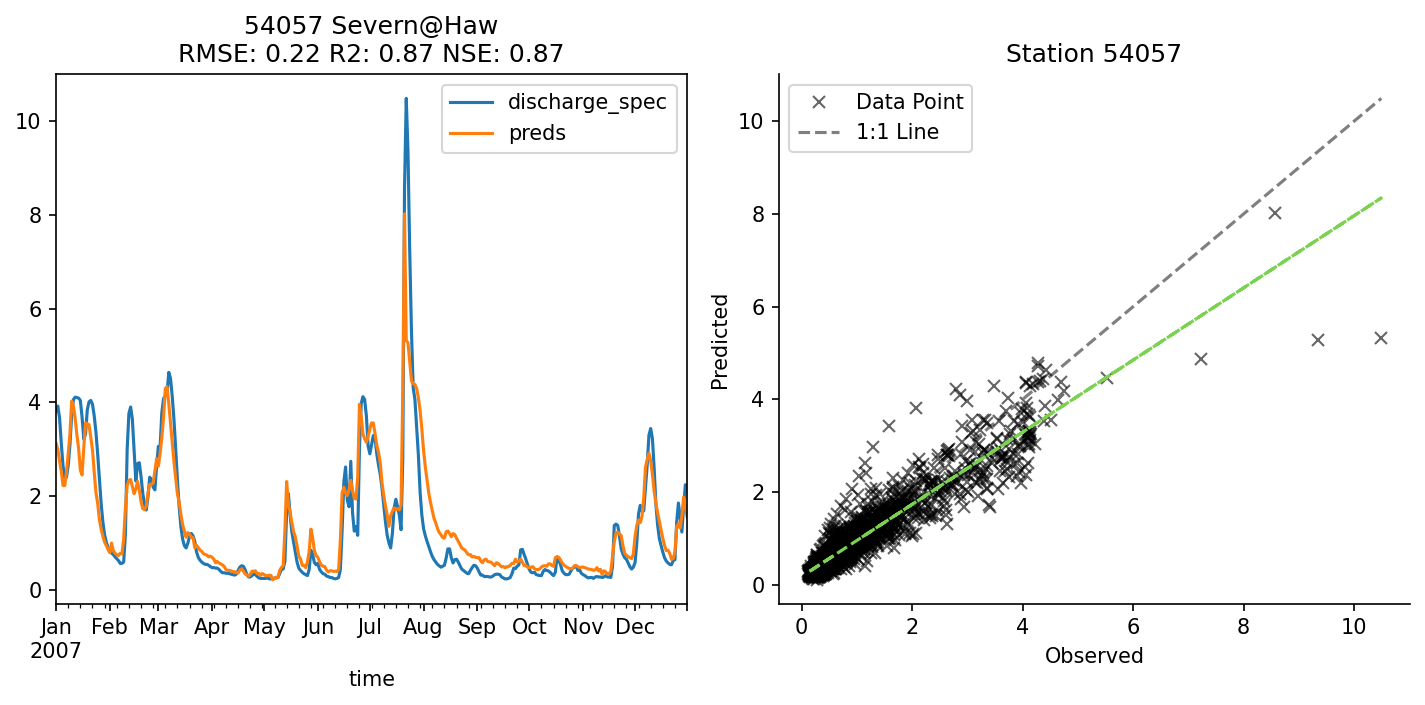

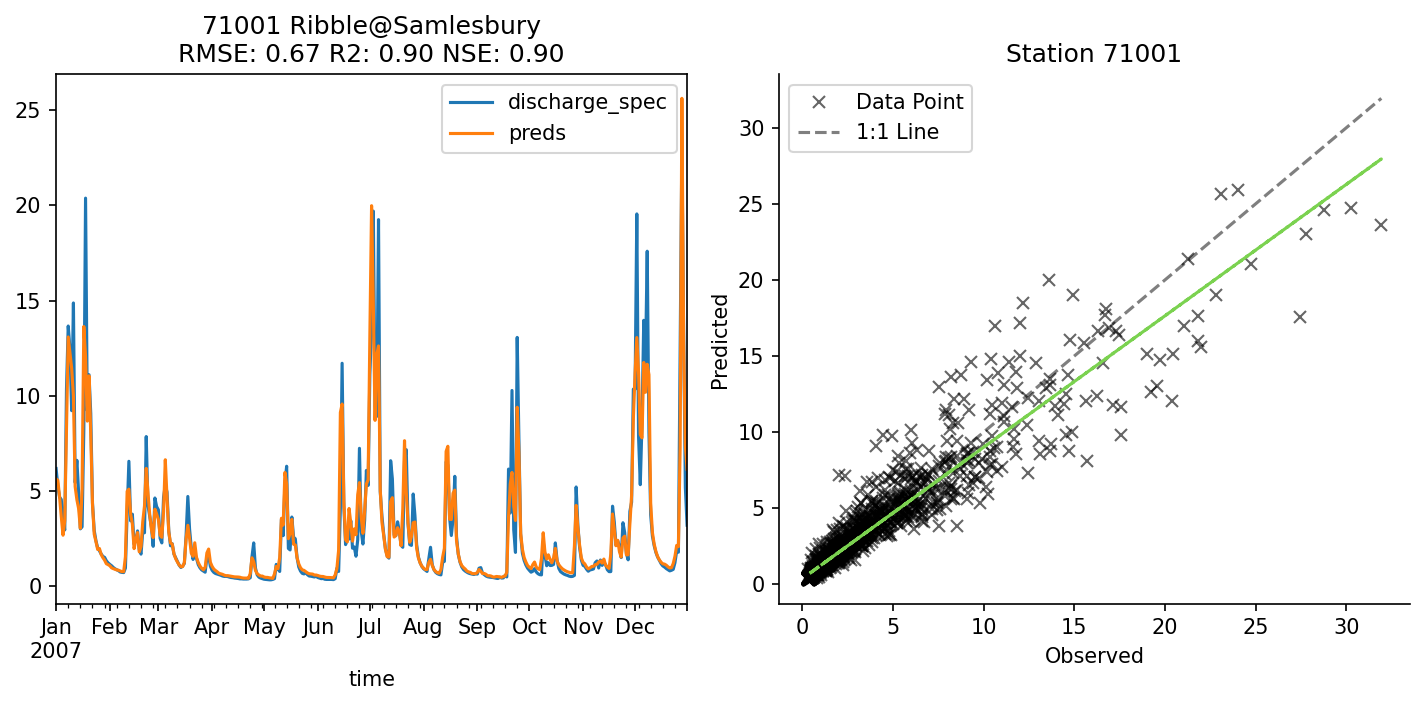

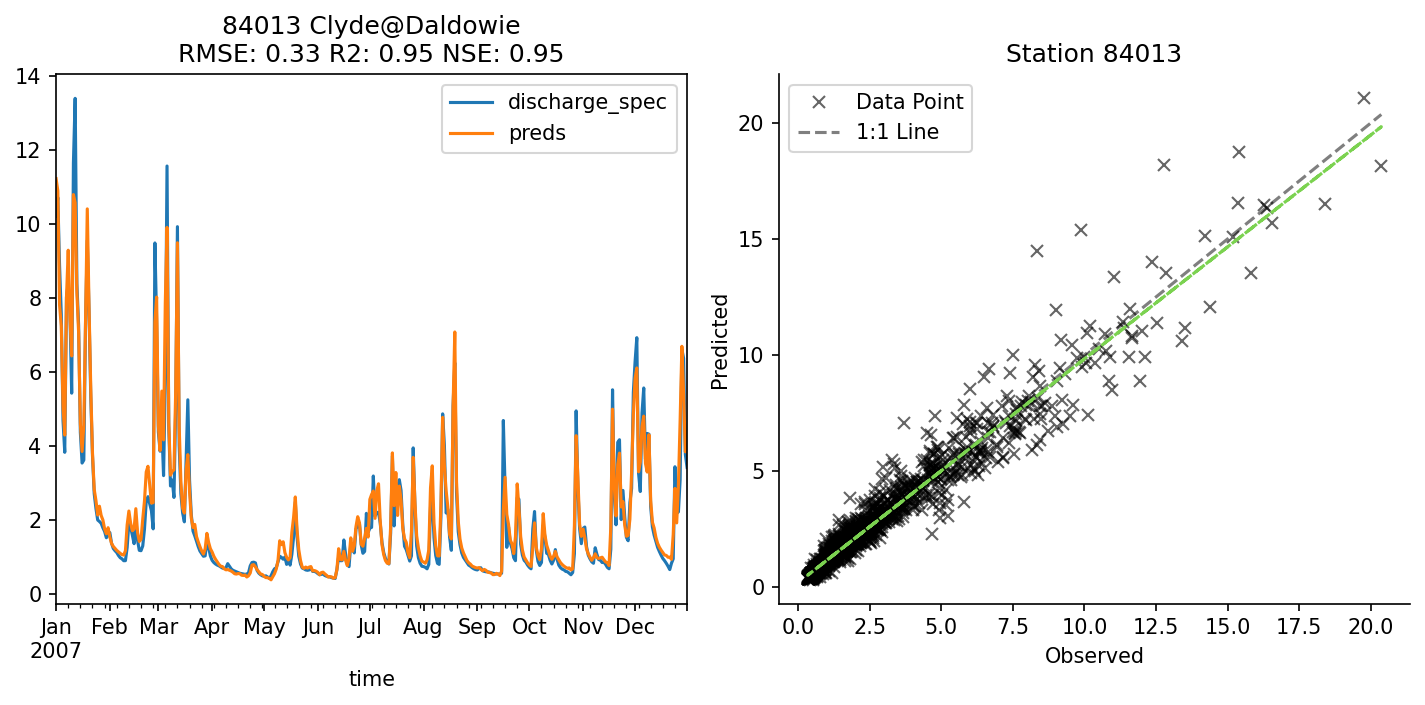

In [260]:
model = "LSTM"
df = lstm_preds.to_dataframe().reset_index().set_index("time").rename(columns={"obs": "discharge_spec", 'sim': 'preds'})

plot_years = 2007 # [2014]
scale = 0.8
# fig, axs = plt.subplots(13, 2, figsize=(12*scale, 6*scale*13))

for ix, (station_id, station_name) in enumerate(zip(catchment_ids, catchment_names)):
    fig, axs = plt.subplots(1, 2, figsize=(12*scale, 6*scale))
    try:
        plot_station(df, int(station_id), lstm_df, ax=axs[0], station_name=station_name, plot_years=plot_years)  # axs[ix, 0]
        plot_station_scatter(df, int(station_id), lstm_13, ax=axs[1])  # axs[ix, 1]
    except TypeError:
        print(f"** {station_name} data for years {plot_years if plot_years is not None else 'any'} does not exist in the predictions! **")
        
    plt.tight_layout()
    fig.savefig(data_dir / f"gcloud/plots/hydrographs/{station_id}_{station_name}_{model}_hydrograph.png")

# fig.tight_layout(rect=[0, 0.03, 1, 0.965])
# fig.suptitle("LSTM")

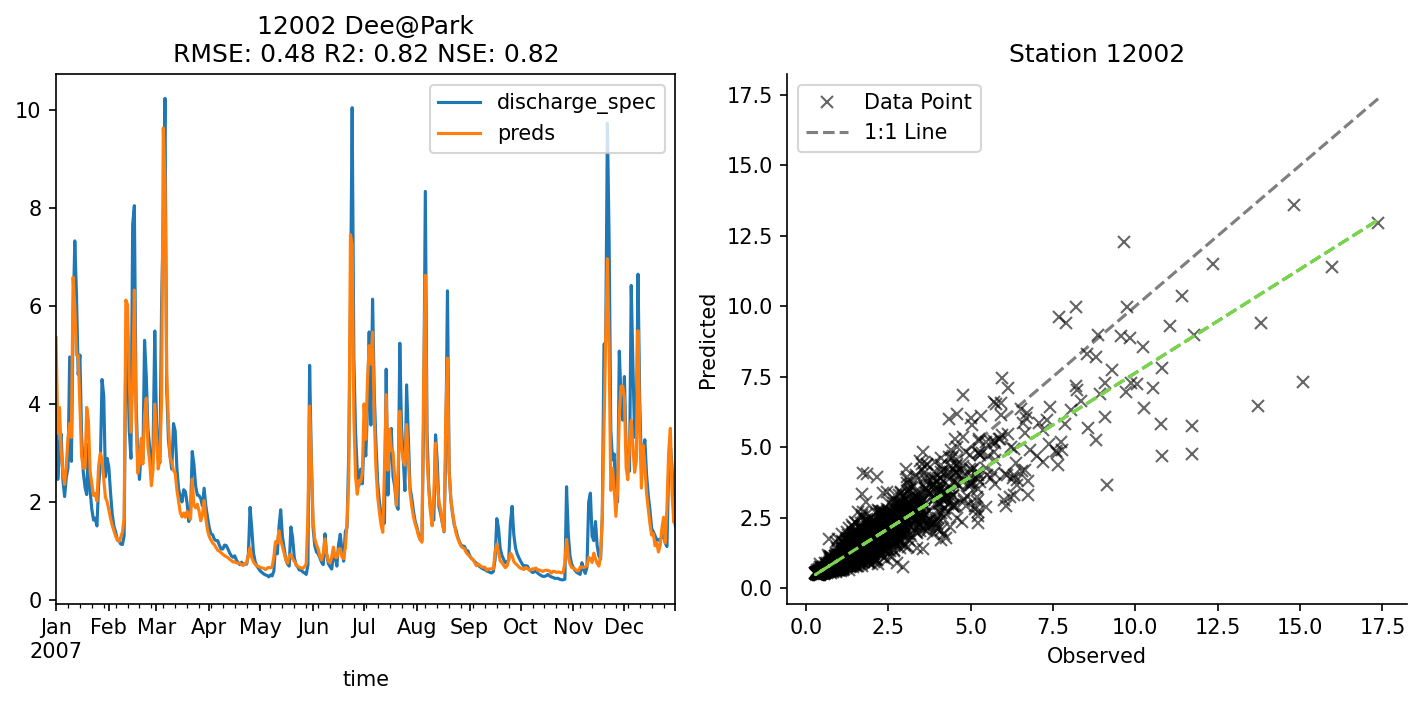

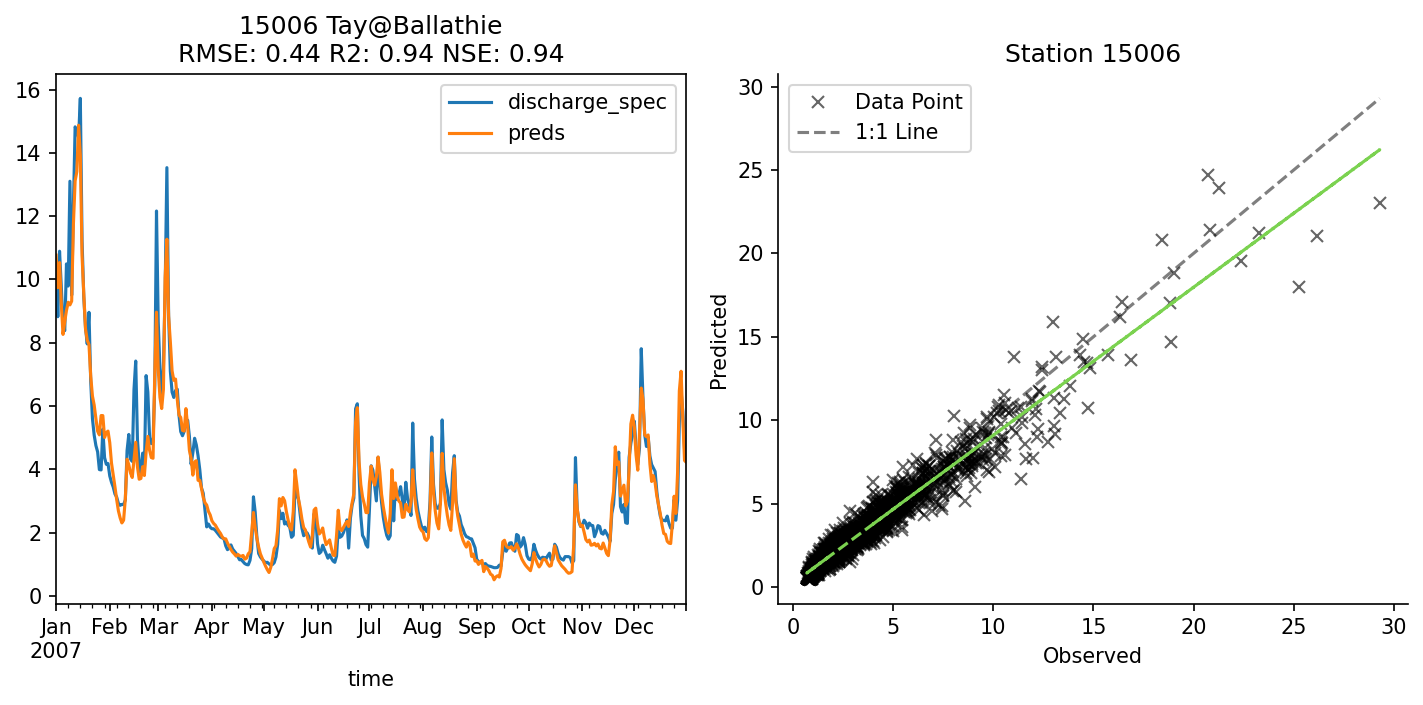

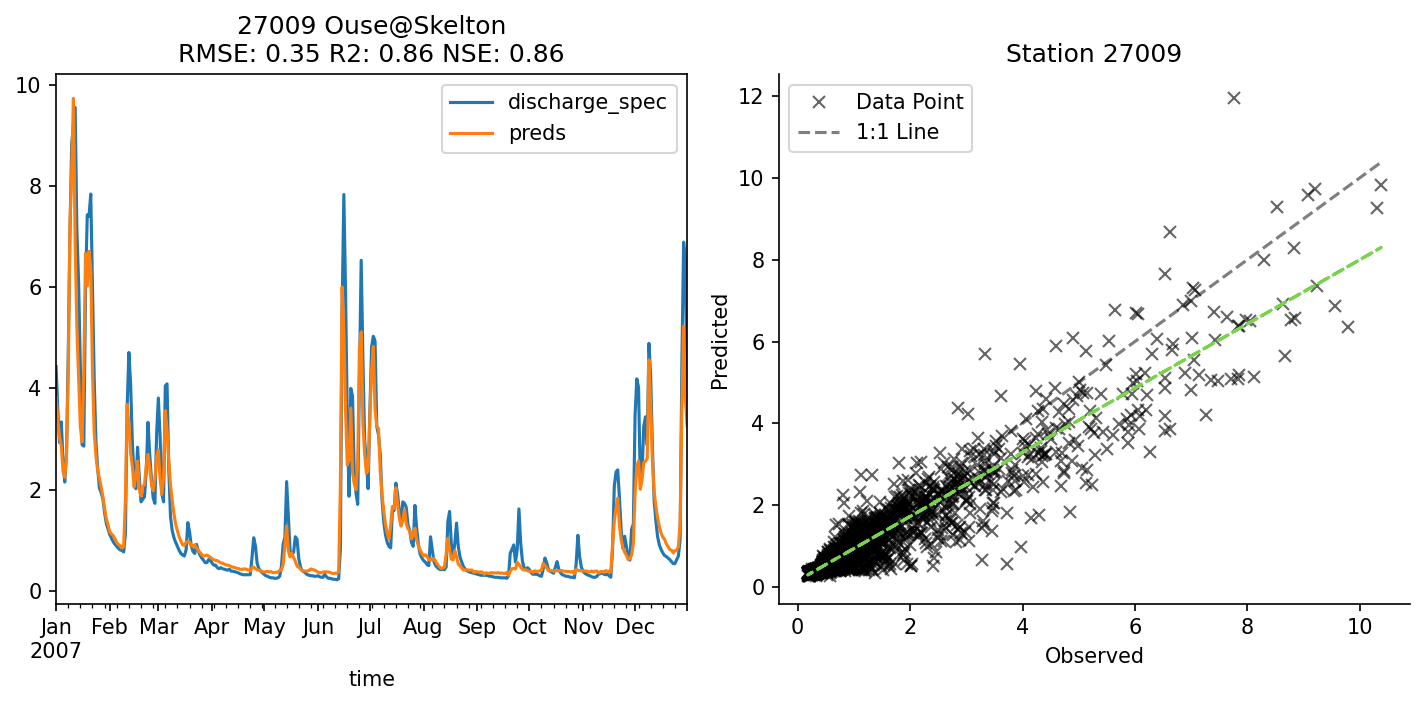

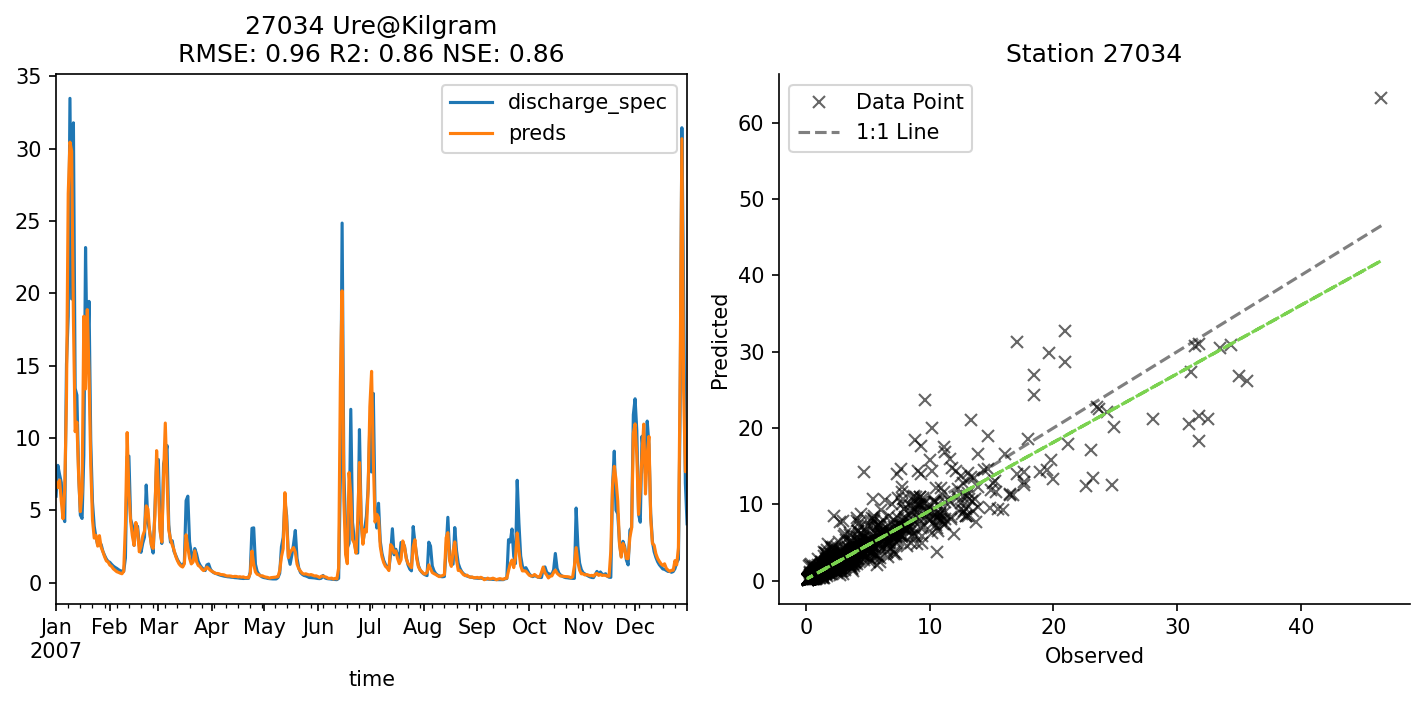

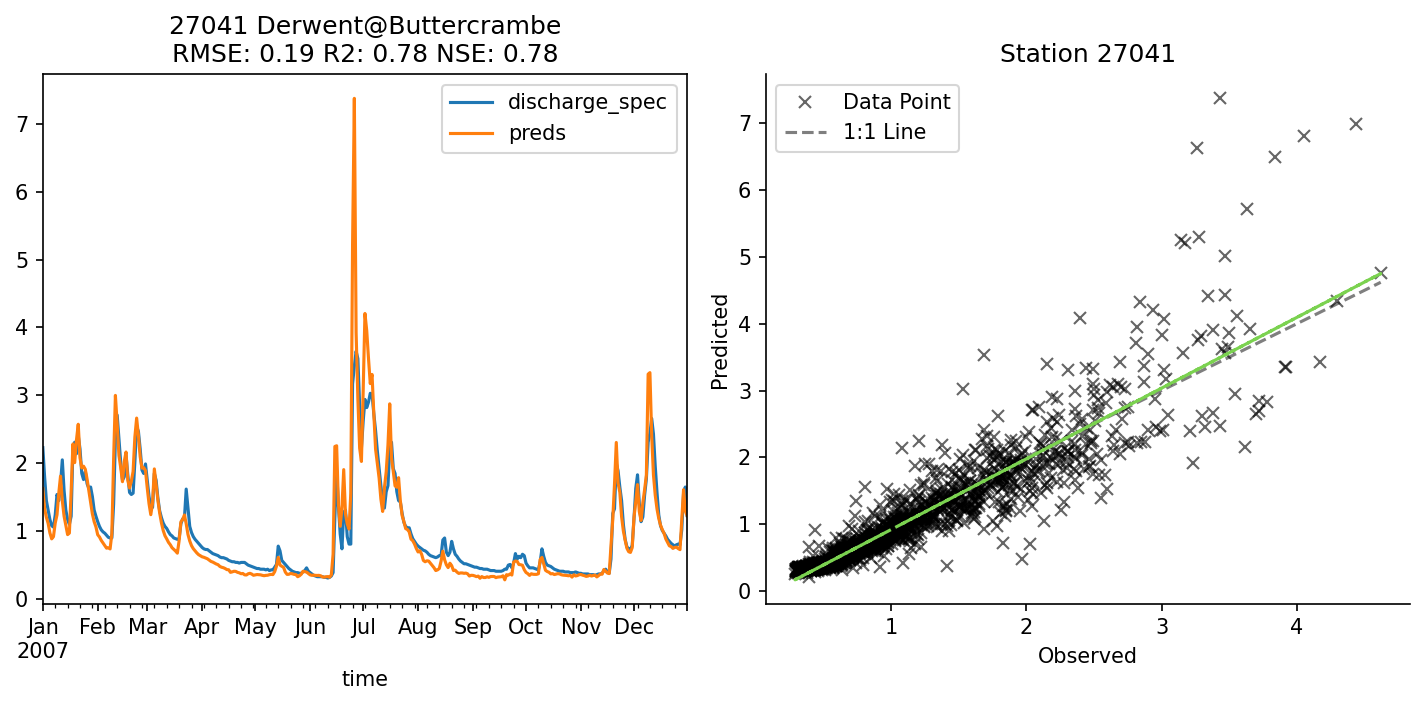

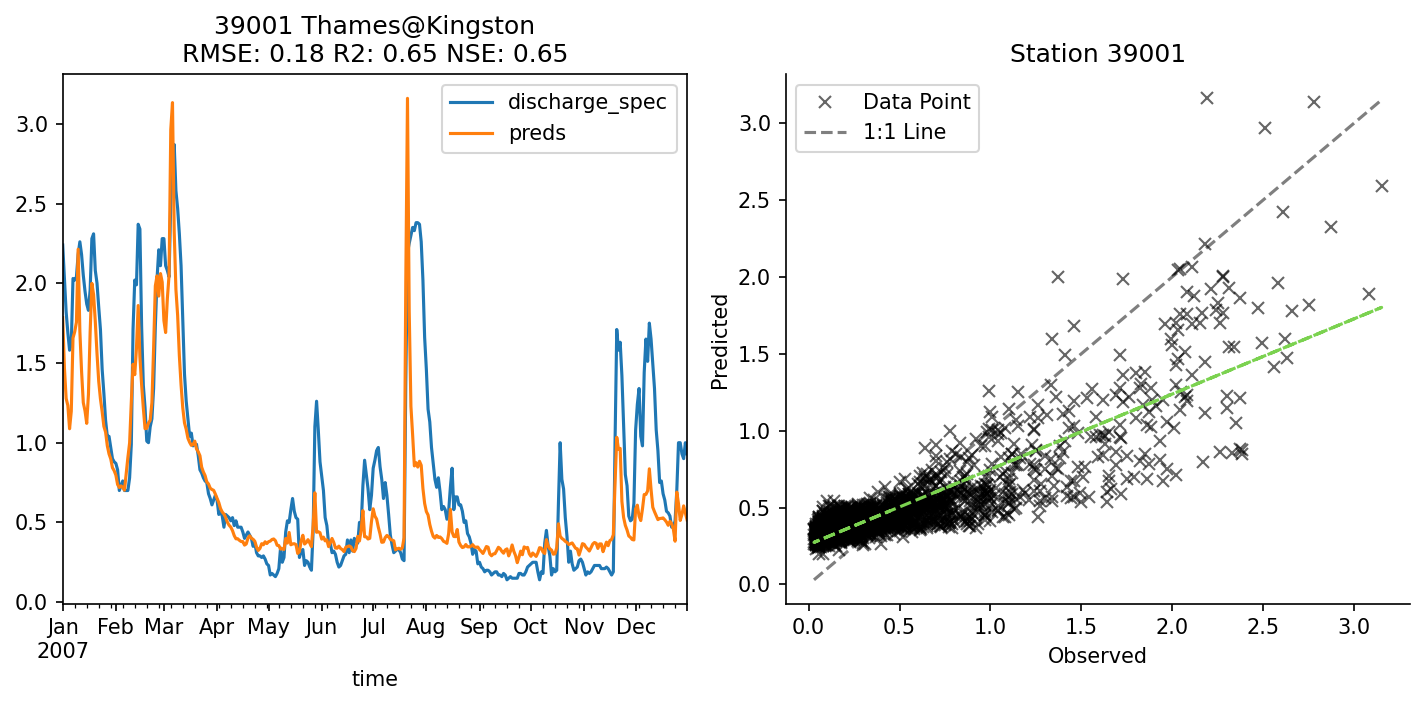

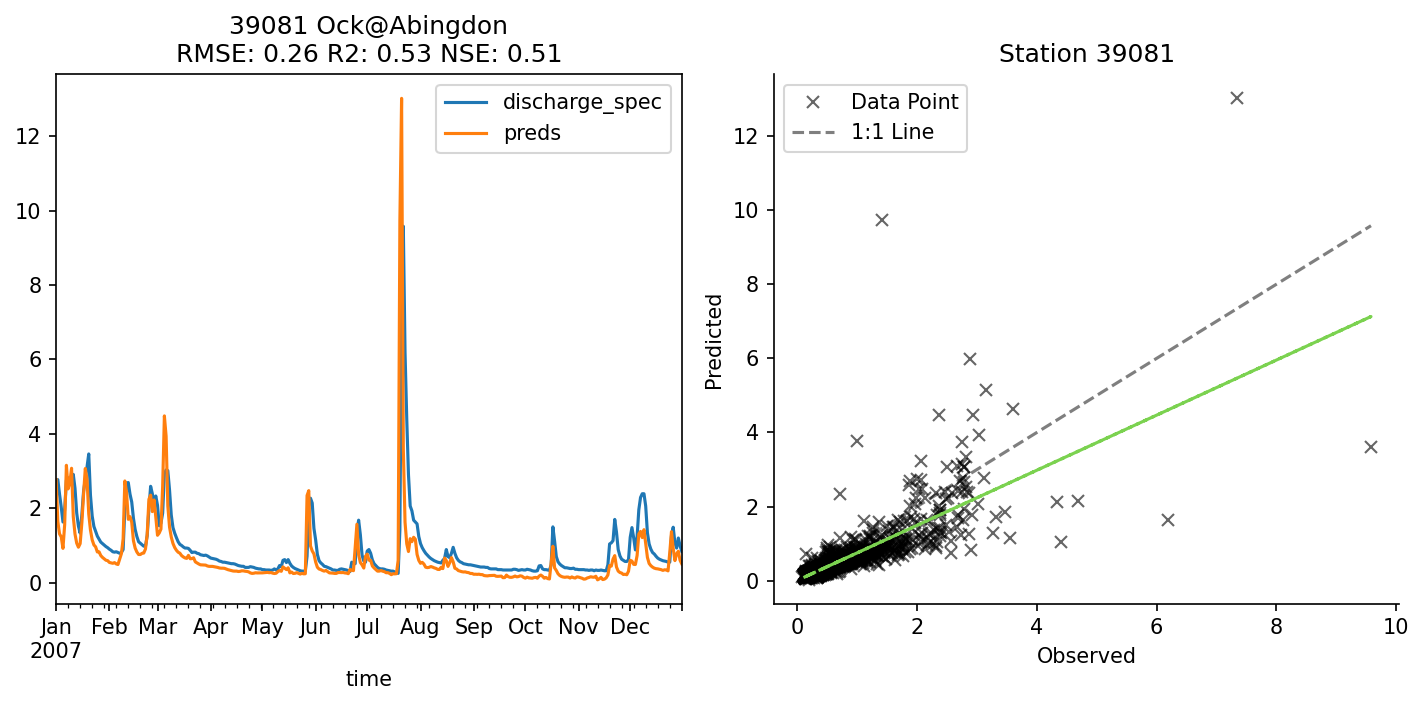

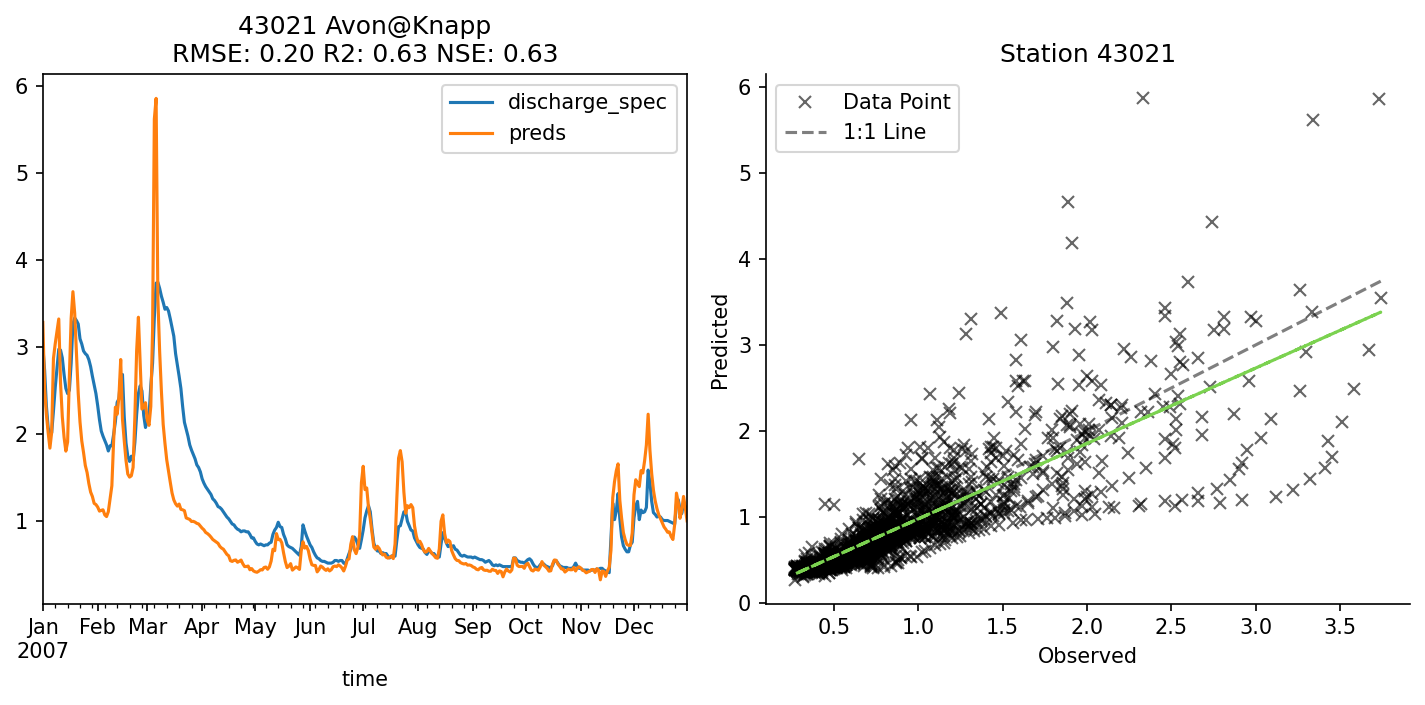

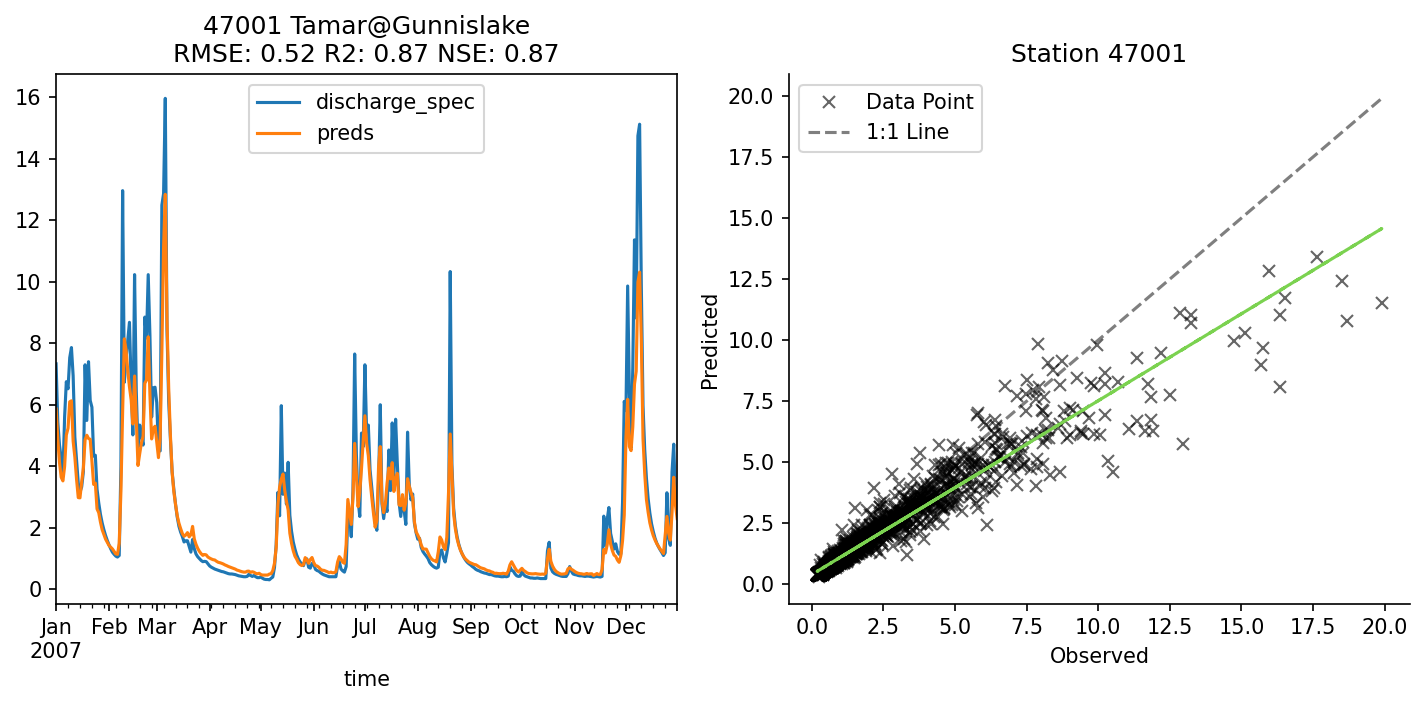

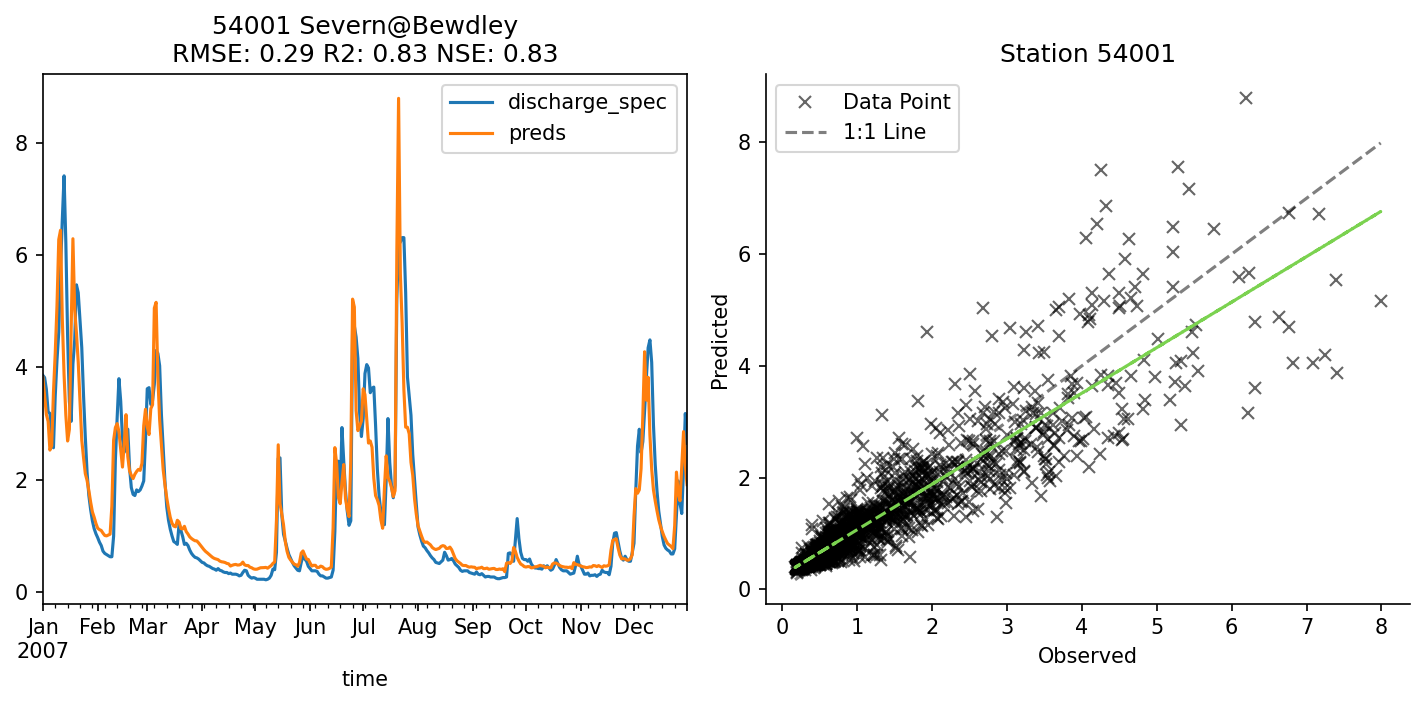

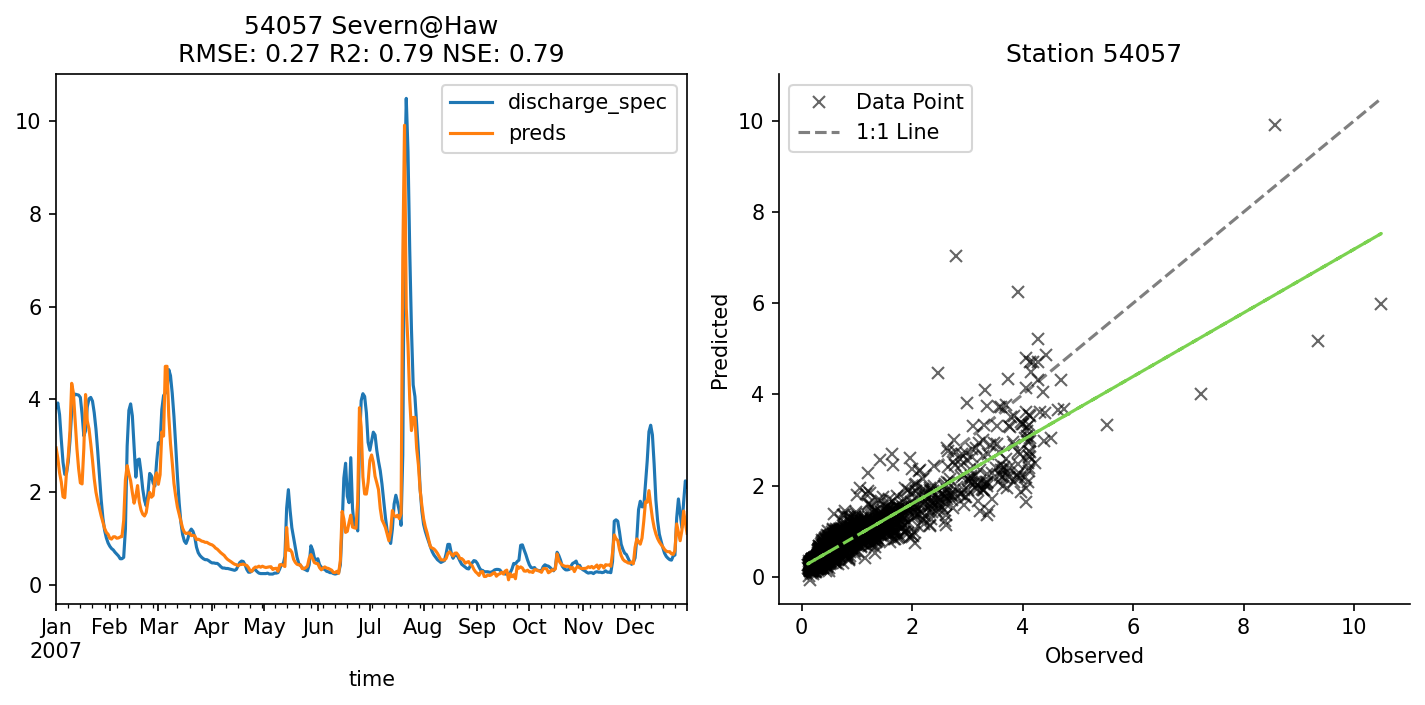

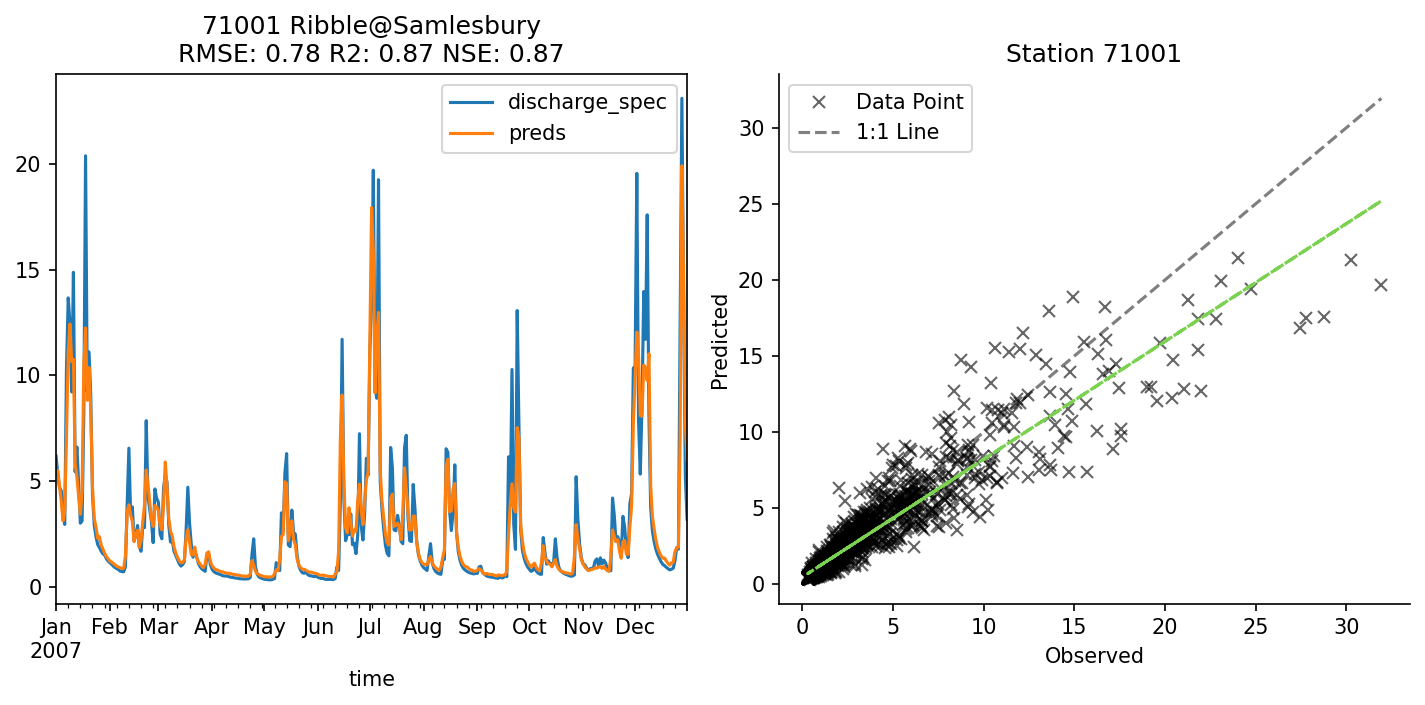

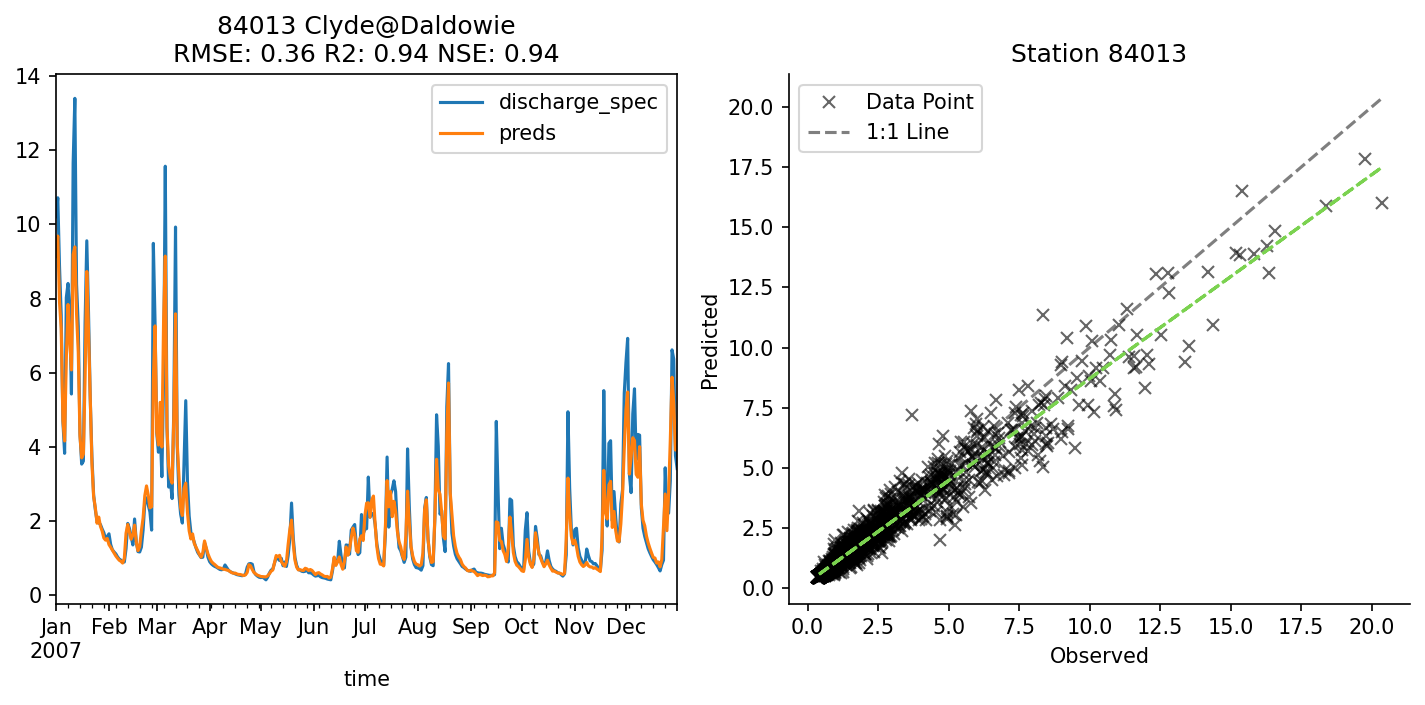

In [261]:
model = "EALSTM"
df = ealstm_preds.to_dataframe().reset_index().set_index("time").rename(columns={"obs": "discharge_spec", 'sim': 'preds'})

plot_years = 2007 # [2014]
scale = 0.8
# fig, axs = plt.subplots(13, 2, figsize=(12*scale, 6*scale*13))

for ix, (station_id, station_name) in enumerate(zip(catchment_ids, catchment_names)):
    fig, axs = plt.subplots(1, 2, figsize=(12*scale, 6*scale))
    try:
        plot_station(df, int(station_id), ealstm_df, ax=axs[0], station_name=station_name, plot_years=plot_years)  # axs[ix, 0]
        plot_station_scatter(df, int(station_id), ealstm_13, ax=axs[1])  # axs[ix, 1]
    except TypeError:
        print(f"** {station_name} data for years {plot_years if plot_years is not None else 'any'} does not exist in the predictions! **")
        
    plt.tight_layout()
    fig.savefig(data_dir / f"gcloud/plots/hydrographs/{station_id}_{station_name}_{model}_hydrograph.png")

# fig.tight_layout(rect=[0, 0.03, 1, 0.965])
# fig.suptitle("LSTM")

# Geographical Plots

nse        r2      rmse       bias  p_mean
station_id                                                 
1001        0.805539  0.806728  0.527684   9.650346    2.65
2001        0.838357  0.839687  0.574231 -10.079839    3.06
2002        0.855312  0.855384  0.728972  -2.861142    3.41
3003        0.879971  0.879972  1.256268  -0.342679    5.39
4001        0.862466  0.862888  0.818045  -3.869403    5.03
...              ...       ...       ...        ...     ...
101002      0.694080  0.710547  0.211854 -19.911354    2.31
101005      0.822549  0.823549  0.149159   7.463119    2.29
102001      0.805450  0.805537  0.808127  -3.544355    2.98
106001      0.869408  0.869457  0.739264  -1.881066    4.16
107001      0.771348  0.773461  0.693627  10.590620    3.16

[667 rows x 5 columns]

In [142]:
import geopandas as gpd

shp_path = Path(
    "/home/jovyan/runoff_uk_lstm/data/CAMELS/CAMELS_GB_DATASET/Catchment_Boundaries/CAMELS_GB_catchment_boundaries.shp"
)
assert shp_path.exists()

In [143]:
# load in the shapefile
geo_df = gpd.read_file(shp_path)
geo_df['ID_STRING'] = geo_df['ID_STRING'].astype('int')

In [176]:
# create spatial dataframe
assert lstm_df['station_id'].dtype == geo_df['ID_STRING'].dtype, "Need to be the same type (integer)"
lstm_gdf = gpd.GeoDataFrame(
    geo_df.set_index('ID_STRING').join(lstm_df.set_index('station_id').join(static['p_mean'].to_dataframe()))
)

In [181]:
# create spatial dataframe
assert ealstm_df['station_id'].dtype == geo_df['ID_STRING'].dtype, "Need to be the same type (integer)"
ealstm_gdf = gpd.GeoDataFrame(
    geo_df.set_index('ID_STRING').join(ealstm_df.set_index('station_id').join(static['p_mean'].to_dataframe()))
)

ealstm_gdf.head()

ID                       SOURCE VERSION    EXPORTED  \
ID_STRING                                                              
10002       10002.0  National River Flow Archive     1.3  2018-02-12   
10003       10003.0  National River Flow Archive     1.3  2018-02-12   
1001         1001.0  National River Flow Archive     1.3  2018-02-12   
101002     101002.0  National River Flow Archive     1.3  2018-02-12   
101005     101005.0  National River Flow Archive     1.3  2018-02-12   

                                                    geometry       nse  \
ID_STRING                                                                
10002      POLYGON ((410125.0000999998 848525.0000999998,...  0.798995   
10003      POLYGON ((394725.0000999998 830350.0000999998,...  0.861841   
1001       POLYGON ((326225.0000999998 954900.0000999998,...  0.786583   
101002     POLYGON ((450375.0000999998 88125.00009999983,...  0.518656   
101005     POLYGON ((453125.0000999998 83525.00009999983,...  0.692758   

                 r2      rmse       bias  p_mean  
ID_STRING                                         
10002      0.812860  0.326525 -24.132489    2.29  
10003      0.866365  0.228373 -13.878043    2.31  
1001       0.786646  0.552805   2.112929    2.65  
101002     0.565190  0.265742 -27.309328    2.31  
101005     0.694734  0.196269   7.975287    2.29

# FUSE Models Spatial Diagrams

# Normalize by mean rainfall?

In [183]:
ealstm_gdf['rmse_norm'] = ealstm_gdf['rmse'] / ealstm_gdf['p_mean']
lstm_gdf['rmse_norm'] = lstm_gdf['rmse'] / lstm_gdf['p_mean']

# Get UK Boundaries

Get the COUNTY SHAPE data [here:](https://opendata.arcgis.com/datasets/1919db8ffcc5445ea4ba5b8a10acfccd_0.zip?outSR=%7B%22latestWkid%22%3A27700%2C%22wkid%22%3A27700%7D)
```
!wget https://opendata.arcgis.com/datasets/1919db8ffcc5445ea4ba5b8a10acfccd_0.zip
!unzip 1919db8ffcc5445ea4ba5b8a10acfccd_0.zip
!mkdir Counties_and_Unitary_Authorities_April_2019_Boundaries_EW_BFC
!mv Counties* Counties_and_Unitary_Authorities_April_2019_Boundaries_EW_BFC
```

Get all of these shapefiles and merge into one big polygon
```python
uk = gpd.read_file(data_dir / "gcloud/Counties_and_Unitary_Authorities_April_2019_Boundaries_EW_BFC/Counties_and_Unitary_Authorities_April_2019_Boundaries_EW_BFC.shp")
uk.plot()

from shapely.ops import unary_union  # cascaded_union, 
uk_bound = unary_union([p for p in uk.geometry])
uk_bound = gpd.GeoSeries(uk_bound)
```

[Link to CRS Discussion](https://communityhub.esriuk.com/geoxchange/2012/3/26/coordinate-systems-and-projections-for-beginners.html#:~:text=If%20you%20work%20with%20UK,that%20you%20should%20know%20about.&text=Web%20Mercator%20is%20a%20PCS,36%20used%20for%20British%20maps)


![title](https://static1.squarespace.com/static/55bb8935e4b046642e9d3fa7/55bb8e8ee4b03fcc125a74c0/55bb8e91e4b03fcc125a7a67/1331725592717/1000w/coordsys_diagram.png)


In [185]:
world = gpd.read_file(data_dir / "gcloud/natural_earth_hires/ne_10m_admin_0_countries.shp")
uk = world.query("ADM0_A3 == 'GBR'")
# uk.plot(facecolor='none', edgecolor='k')

In [186]:
ealstm_gdf.crs = None
ealstm_gdf.crs = {'init' :'epsg:27700'}  # 4277  27700
lstm_gdf.crs = {'init' :'epsg:27700'}  

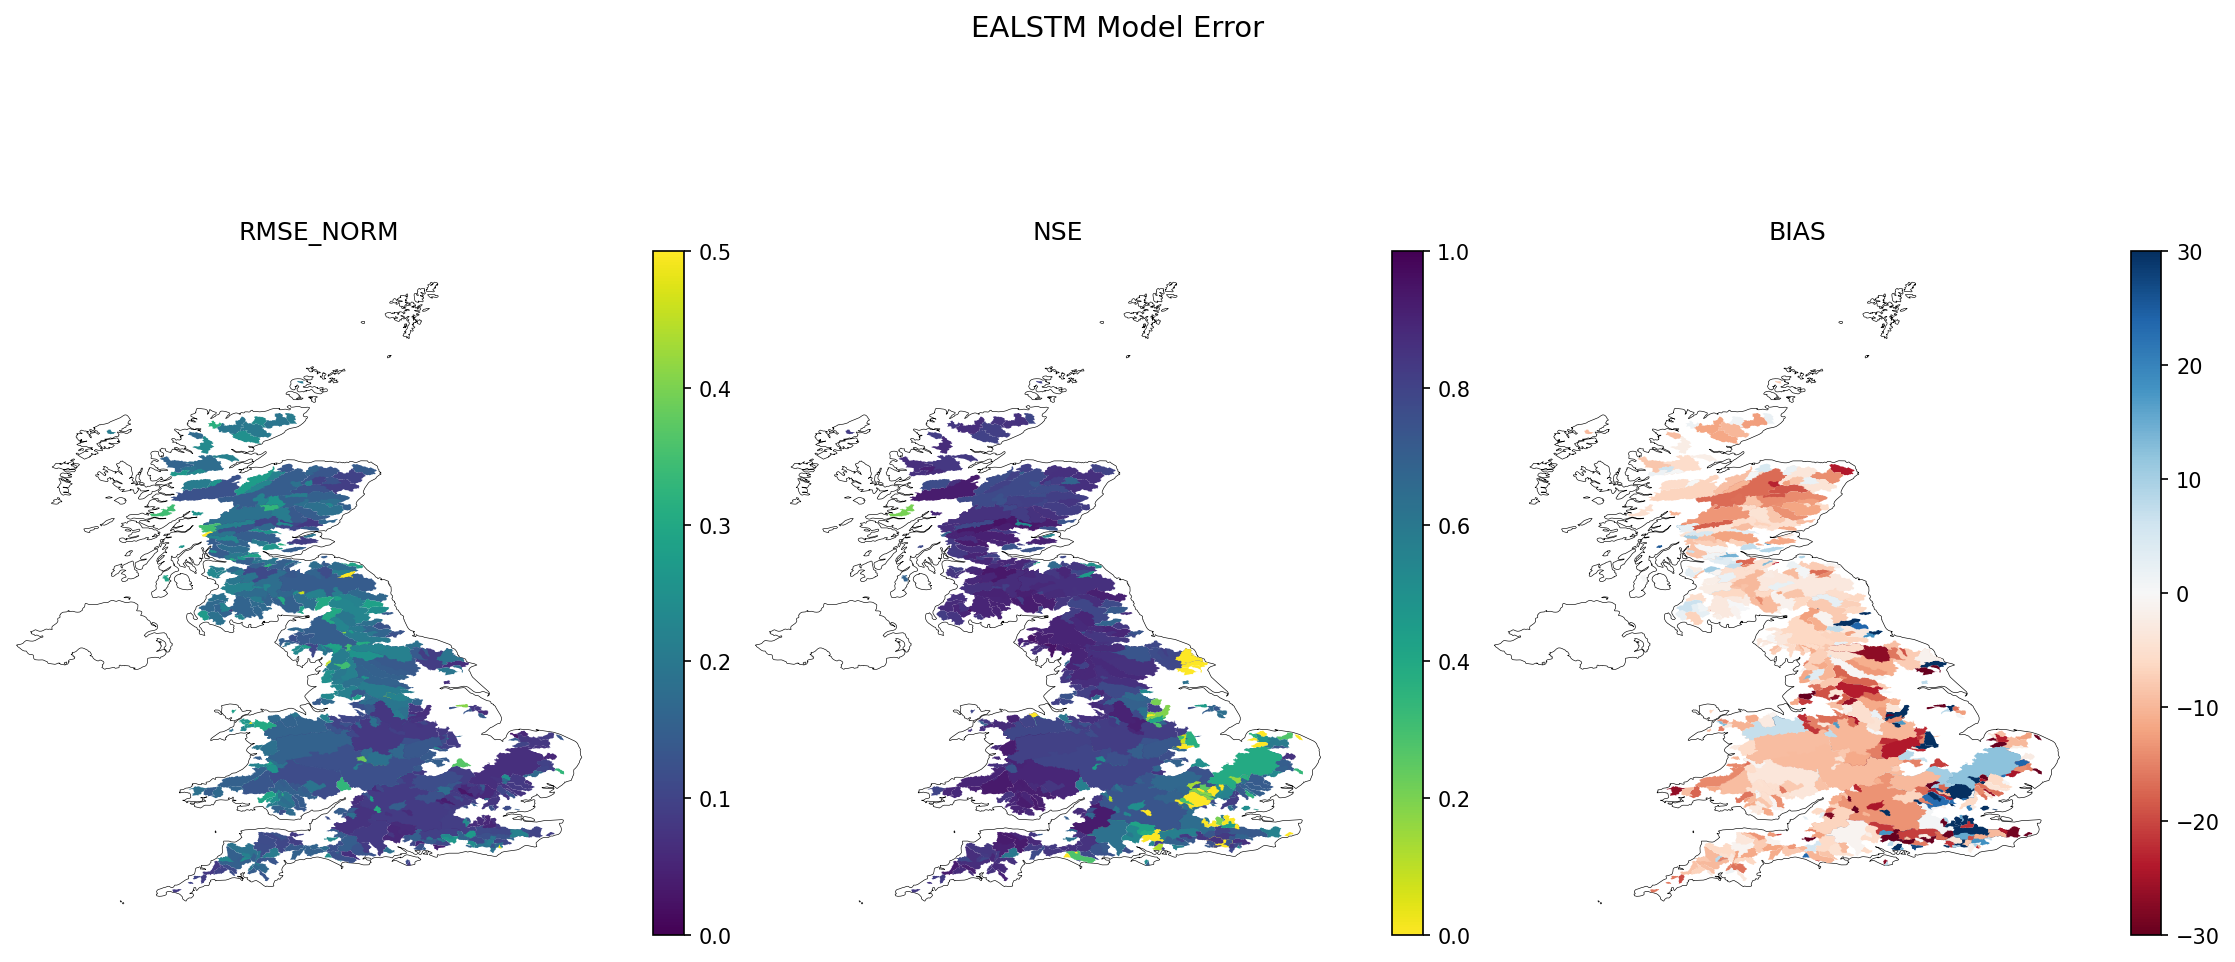

In [191]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, axs = plt.subplots(1, 3, figsize=(15, 8))

metric = "nse"
opts = {
    "rmse": {"vmin": 0, "vmax": 1, 'cmap': 'viridis'},   # rmse   
    "rmse_norm": {"vmin": 0, "vmax": 0.5, 'cmap': 'viridis'},   # rmse   
    "nse": {"vmin": 0, "vmax": 1, 'cmap': 'viridis_r'},    # nse   
    "r2": {"vmin": 0, "vmax": 1, 'cmap': 'viridis_r'},    # r2  
    "bias": {"vmin": -30, "vmax": 30, 'cmap': 'RdBu'}    # r2  
}

for ix, metric in enumerate(["rmse_norm", "nse", "bias"]):
    ax = axs[ix]
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2) # depends on the user needs

    # plot the surrounding lines
    uk.plot(facecolor='none', edgecolor='k', ax=ax, linewidth=0.3)
    # plot the chloropleth
    ealstm_gdf.to_crs(epsg=4326).plot(metric, ax=ax, legend=True, cax=cax, **opts[metric]);

    # for key in ax.spines.keys():
    #     ax.spines[key].set_visible(False)
    ax.set_xlim([-8.2, 2.5])
    ax.axis('off');

    ax.set_title(metric.upper())
    
fig.tight_layout(rect=[0, 0.03, 1, 0.965])
fig.suptitle("EALSTM Model Error", size=14);

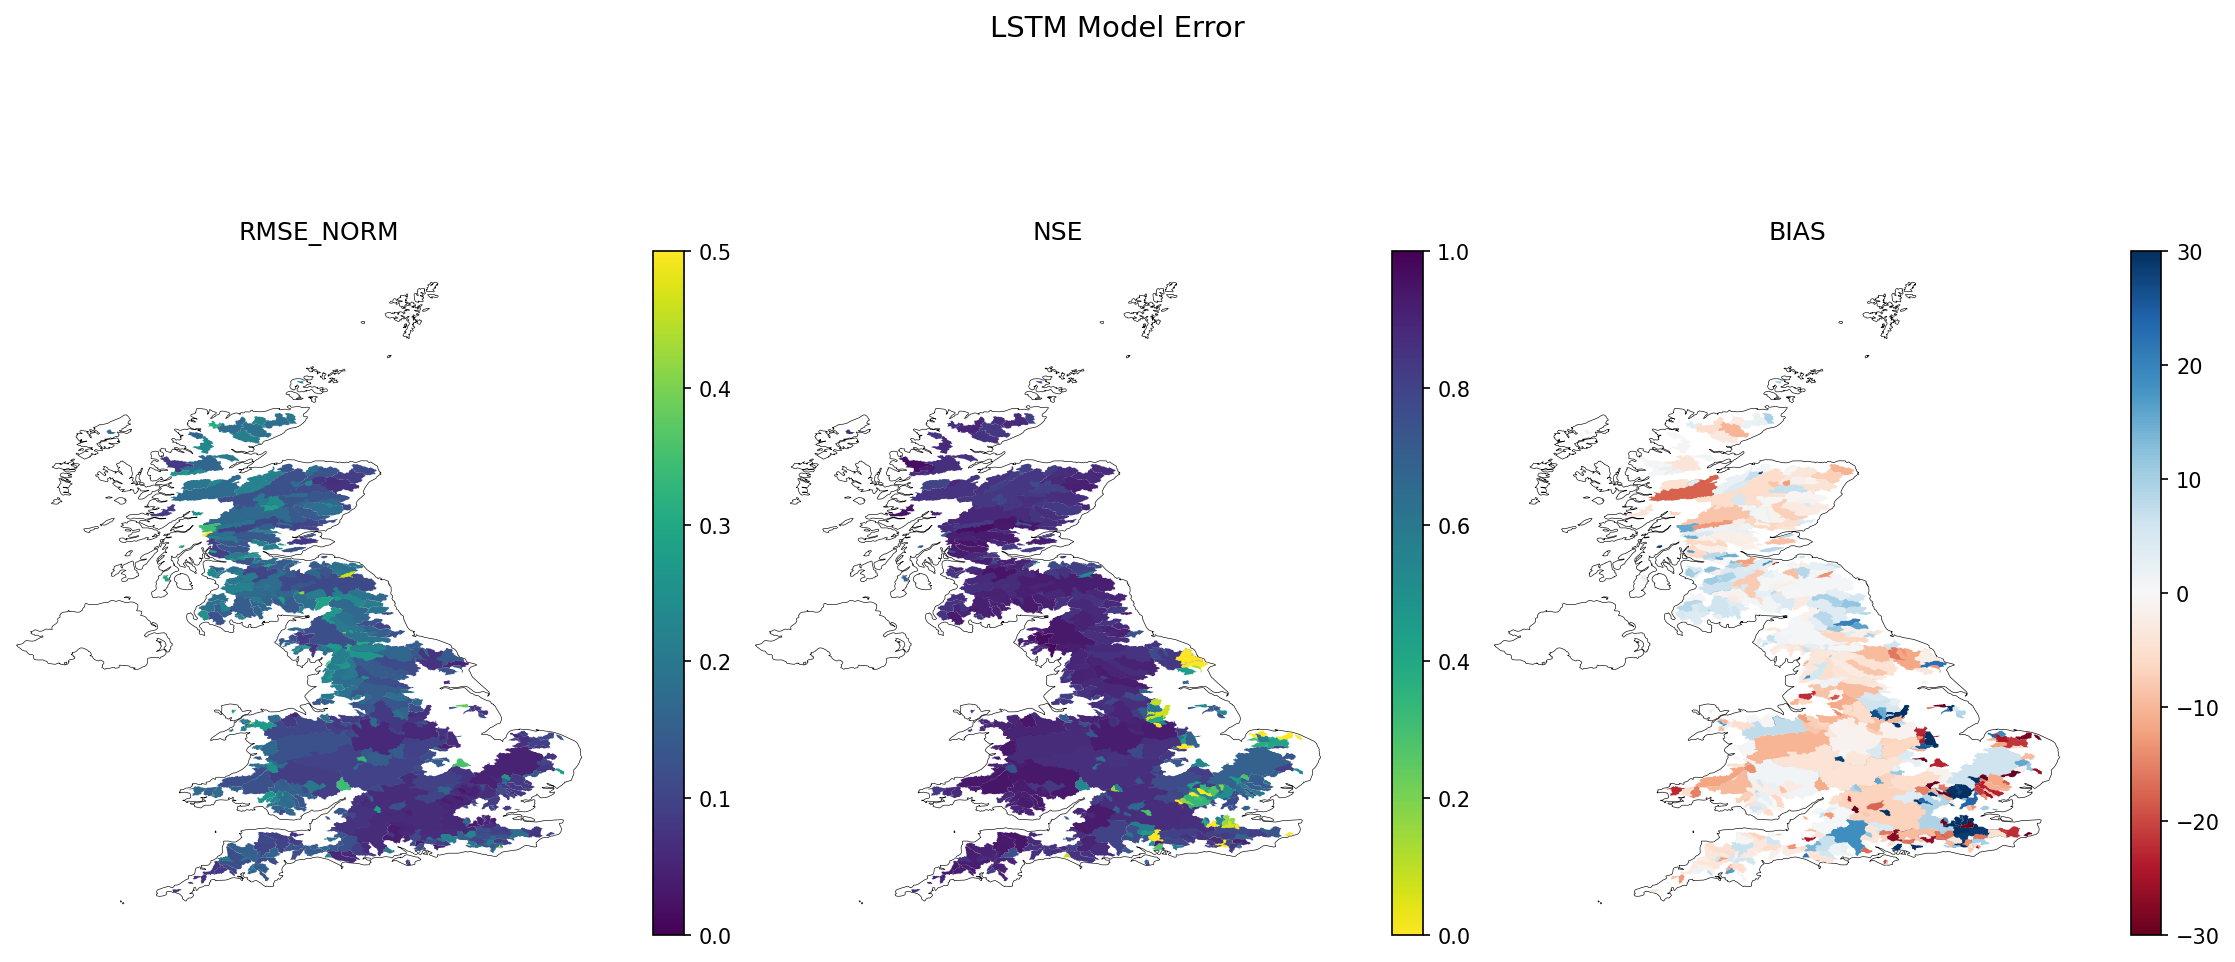

In [192]:
fig, axs = plt.subplots(1, 3, figsize=(15, 8))

for ix, metric in enumerate(["rmse_norm", "nse", "bias"]):
    ax = axs[ix]
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2) # depends on the user needs

    # plot the surrounding lines
    uk.plot(facecolor='none', edgecolor='k', ax=ax, linewidth=0.3)
    # plot the chloropleth
    lstm_gdf.to_crs(epsg=4326).plot(metric, ax=ax, legend=True, cax=cax, **opts[metric]);

    # for key in ax.spines.keys():
    #     ax.spines[key].set_visible(False)
    ax.set_xlim([-8.2, 2.5])
    ax.axis('off');

    ax.set_title(metric.upper())
    
fig.tight_layout(rect=[0, 0.03, 1, 0.965])
fig.suptitle("LSTM Model Error", size=14);

# Locations of 13 test catchments

In [150]:
stations = static.station_id.values
names = static.gauge_name.values
latlons = np.array(list(zip(static.gauge_lat.values, static.gauge_lon.values)))

In [151]:
d = pd.DataFrame({'station_id': stations, 'lat': latlons[:, 0], 'lon': latlons[:, 1], 'name': names})

points = gpd.GeoDataFrame(
    d, geometry=gpd.points_from_xy(d.lon, d.lat)
)
points["id"] = points["station_id"]
points = points.set_index("station_id")
points.crs = {'init' :'epsg:4326'}  
points.head()
# points.plot()

lat   lon                     name             geometry    id
station_id                                                                 
1001        58.48 -3.27          Wick at Tarroul  POINT (-3.27 58.48)  1001
2001        58.14 -3.70   Helmsdale at Kilphedir   POINT (-3.7 58.14)  2001
2002        58.01 -3.88     Brora at Bruachrobie  POINT (-3.88 58.01)  2002
3003        57.96 -4.70  Oykel at Easter Turnaig   POINT (-4.7 57.96)  3003
4001        57.56 -4.54      Conon at Moy Bridge  POINT (-4.54 57.56)  4001

In [152]:
basins = ealstm_gdf.reset_index()[["ID", "geometry"]]
basins = basins.rename(columns={"ID":"station_id"}).set_index("station_id")
basins = basins.join(points.drop(columns="geometry"))
basins.crs = {'init' :'epsg:27700'}  
basins = basins.to_crs(epsg=4326)
basins.head()
# basins.plot()

geometry    lat   lon  \
station_id                                                                   
10002.0     POLYGON ((-1.832591530061402 57.52677172510972...  57.53 -1.83   
10003.0     POLYGON ((-2.089335278407181 57.36359210409901...  57.36 -2.09   
1001.0      POLYGON ((-3.266661394493432 58.47606499610154...  58.48 -3.27   
101002.0    POLYGON ((-1.288209653464926 50.69060168610302...  50.69 -1.29   
101005.0    POLYGON ((-1.2499408102372 50.64899447688404, ...  50.65 -1.25   

                                name      id  
station_id                                    
10002.0            Ugie at Inverugie   10002  
10003.0               Ythan at Ellon   10003  
1001.0               Wick at Tarroul    1001  
101002.0             Medina at Shide  101002  
101005.0    Eastern Yar at Budbridge  101005

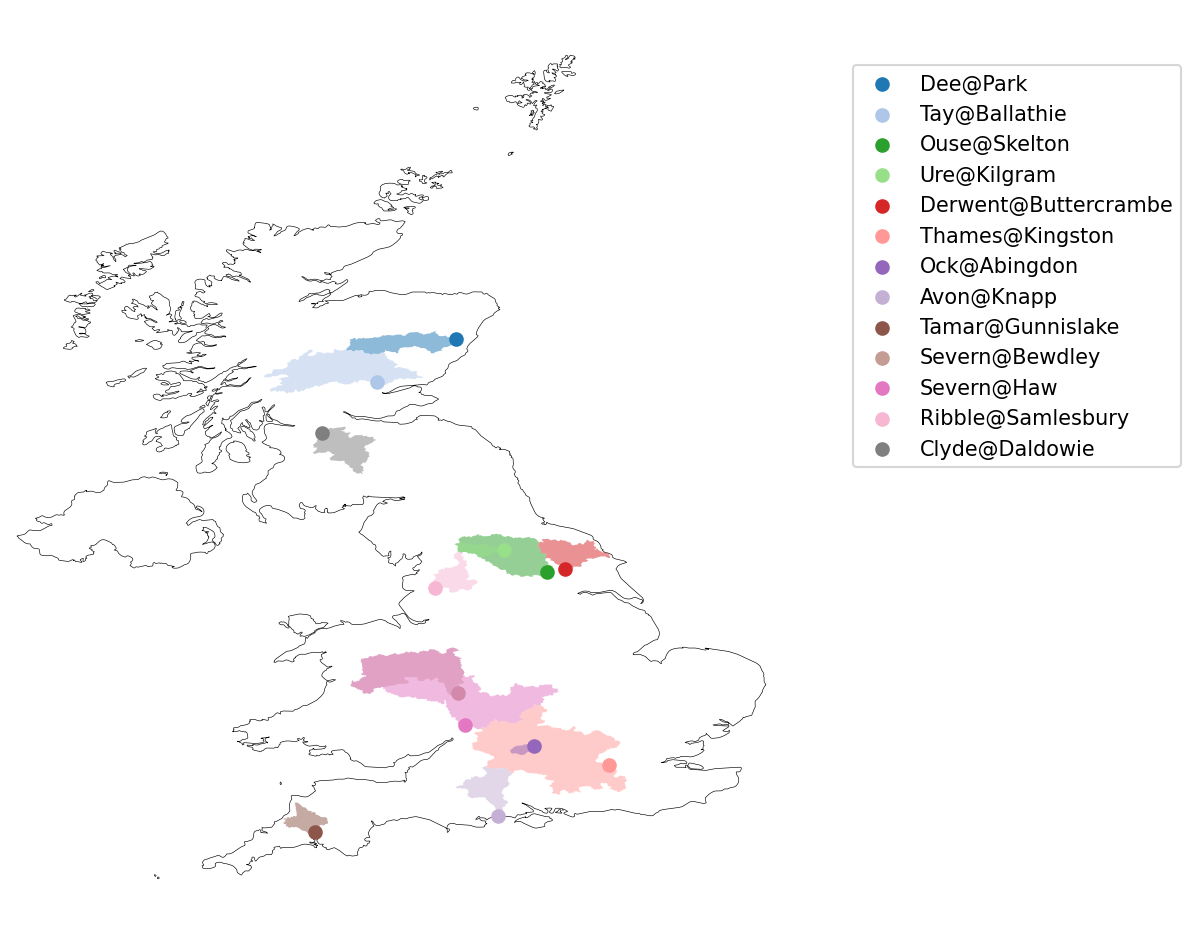

In [153]:
fig, ax = plt.subplots(figsize=(12, 8))
uk.plot(facecolor='none', edgecolor='k', ax=ax, linewidth=0.3)
ax.set_xlim([-8.2, 2.5])
colors = np.array(mpl.cm.get_cmap('tab20').colors)
colors = np.vstack([colors[0:2], colors[4:]])

for ix, (c_id, c_name) in enumerate(zip(catchment_ids, catchment_names)):
    basins.loc[basins["id"] == c_id].plot(ax=ax, alpha=0.5, color=colors[ix])
    points.loc[points["id"] == c_id].plot(ax=ax, label=c_name, categorical=True, color=colors[ix])

plt.legend(loc=(1.04, 0.5))
ax.axis('off');

# 10 Worst Performing Catchments

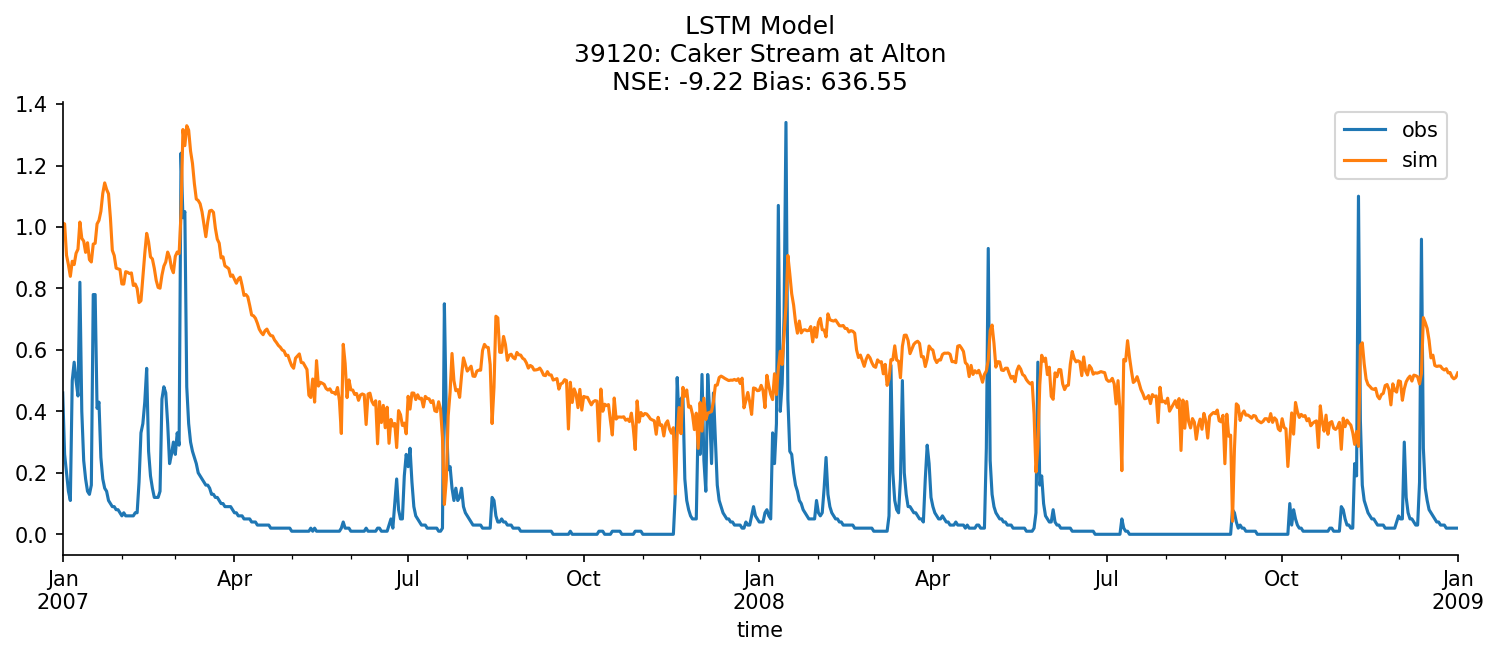

In [239]:
big_bias = lstm_preds.sel(station_id=lstm_gdf.loc[lstm_gdf['bias'].argmax()].ID)

fig, ax = plt.subplots(figsize=(12, 4))
station_id = big_bias.station_id.values
station_name = static['gauge_name'].sel(station_id=station_id).values
errors = lstm_df.loc[lstm_df["station_id"] == station_id]

big_bias.to_dataframe().drop('station_id', axis=1).loc["2007": "2009"].plot(ax=ax)

ax.set_title(f"LSTM Model\n{station_id}: {station_name}\nNSE: {float(errors['nse'].values):.2f} Bias: {float(errors['bias'].values):.2f}")

sns.despine()

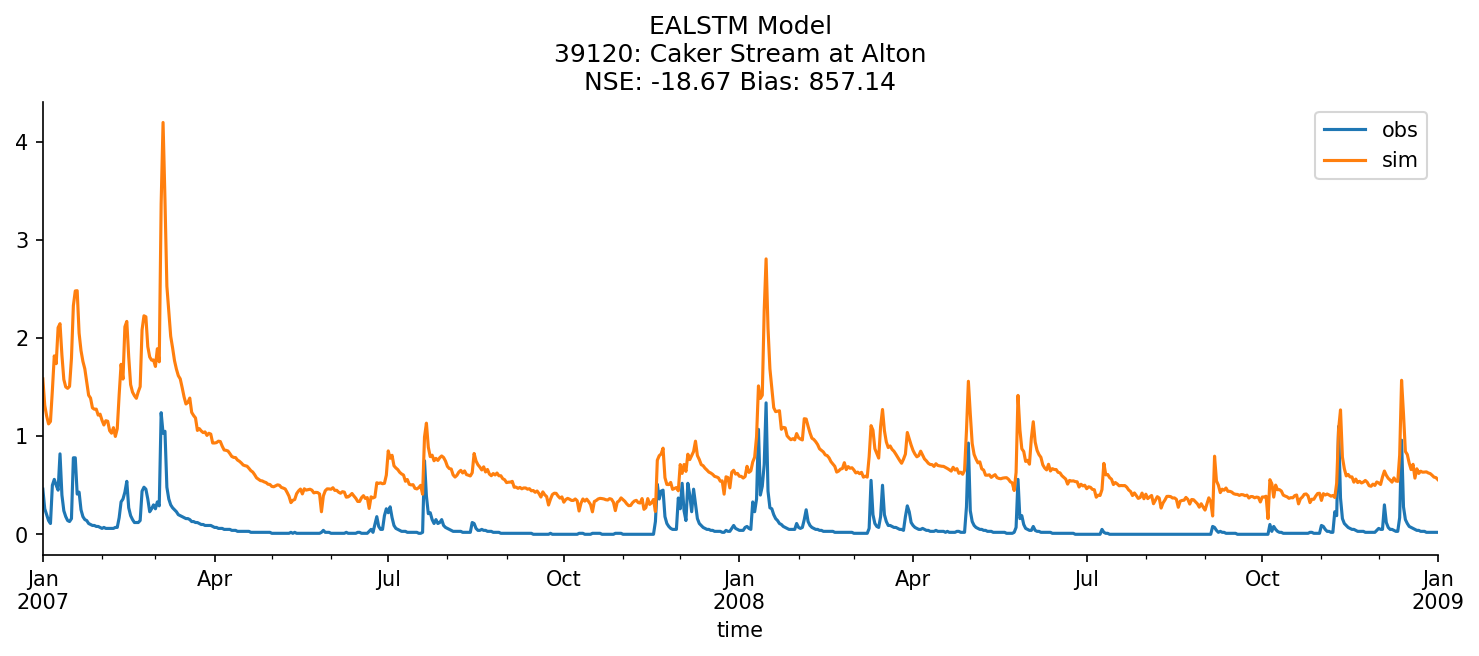

In [242]:
big_bias = ealstm_preds.sel(station_id=ealstm_gdf.loc[ealstm_gdf['bias'].argmax()].ID)

fig, ax = plt.subplots(figsize=(12, 4))
station_id = big_bias.station_id.values
station_name = static['gauge_name'].sel(station_id=station_id).values
errors = ealstm_df.loc[ealstm_df["station_id"] == station_id]

big_bias.to_dataframe().drop('station_id', axis=1).loc["2007": "2009"].plot(ax=ax)

ax.set_title(f"EALSTM Model\n{station_id}: {station_name}\nNSE: {float(errors['nse'].values):.2f} Bias: {float(errors['bias'].values):.2f}")

sns.despine()

In [253]:
fuse_data = xr.open_dataset(data_dir / 'gcloud/fuse_data.nc')
fuse_data.sel(station_id=station_id)

KeyError: 39120

In [256]:
fuse_data.to_dataframe().to_csv(data_dir / 'gcloud/fuse_csv.csv')

# Performance at the extremes

In [244]:
lstm_preds['obs']

<xarray.DataArray 'obs' (station_id: 667, time: 1828)>
array([[ 9.16,  6.23,  5.6 , ...,  0.55,  0.56,  0.48],
       [ 4.11,  3.55,  7.36, ...,  0.78,  1.  ,  0.9 ],
       [ 2.26,  3.45,  6.13, ...,  0.54,  0.44,  0.44],
       ...,
       [ 6.37,  3.1 ,  3.  , ...,  1.2 ,  1.14,  1.11],
       [12.87,  8.09,  5.97, ...,  2.53,  2.33,  2.17],
       [ 9.08,  4.18,  3.48, ...,  1.04,  0.94,  0.95]])
Coordinates:
  * station_id  (station_id) int64 1001 2001 2002 3003 ... 102001 106001 107001
  * time        (time) datetime64[ns] 2004-01-01 2004-01-02 ... 2009-01-01